In [1]:
import datasets
import os

words_to_collect = []


"""
1) the words we want to collect data for
"""

bless = datasets.get_bless()

# get all the words
all_words = []
for row in bless:
    w1 = row['word1']
    w2 = row['word2']
    all_words.append(w1)
    all_words.append(w2)
        
unique_words = set(all_words)

for word in unique_words:
    pathname = os.path.join("./data/word_data/", word)
    # collect this new word unless its not new and we already have data for it
    if not os.path.isdir(pathname):
        words_to_collect.append(word)
        

print("Total words in BLESS: %s" % len(all_words))
print("Unique words in BLESS: %s" % len(unique_words))
print("New words that we don't have tokens collected yet for BLESS %s:" % len(words_to_collect))

"""
2) the layers we want to analzye
"""
layers = [0,1,5,11]

"""
3) The cluster sizes we want to analyze
"""
cluster_sizes = [1,3,5,7]

processed 26554 word pairs from BLESS dataset
Total words in BLESS: 53108
Unique words in BLESS: 8026
New words that we don't have tokens collected yet for BLESS 0:


In [4]:
import grinders

# this outfile is going to contain all the bless tokens for words that arent already in WS353, MEN, or VERBSIM
grinders.collect_bnc_tokens_for_words(words_to_collect, override=True, outfile='bnc_words_with_BLESS_tokens.csv')


# Sentences in BNC corpus: 6026276
shuffling indexes
done shuffling
[4163779, 446650, 4643385, 300873, 1297249, 3680078, 3461514, 2089622, 4608985, 1650673, 5285127, 4032856, 5691634, 1625138, 2882927, 4344325, 2810940, 1925609, 4766062, 247747, 3248372, 4791727, 2907285, 4379929, 5386914, 1453484, 1676089, 2501019, 4183002, 4390869, 4842942, 4951264, 3601084, 3345354, 382981, 76605, 252949, 1392862, 5751079, 701938, 5977588, 2043364, 919186, 1867730, 2634390, 4486182, 4552038, 3301970, 2068334, 4839828]
Processed 100000 sentences
Processed 200000 sentences
Processed 300000 sentences
quaint
ADJ
His quaint commentaries made him the voice of the modern game , providing stark contrast to the loud-mouthed antics of some superbrat players .
1336282
stark
ADJ
His quaint commentaries made him the voice of the modern game , providing stark contrast to the loud-mouthed antics of some superbrat players .
1336282
Processed 400000 sentences
Processed 500000 sentences
Processed 600000 sentences
Pro

In [5]:
import os
import csv

ALLWORDS_DIR = './data/word_data'

# you already have tokens collected for each word in simlex and wordsim
# now these tokens ought to be sorted into their own files

# ensure that there is a word_data directory to store in our words
# you have to delete it first with rm -rf if we are reloading
# os.mkdir(ALLWORDS_DIR)


# create files for each word we care about
for word in words_to_collect:
    word_dir = os.path.join(ALLWORDS_DIR, word)
    os.mkdir(word_dir)


# read in the big long file
with open('./data/bnc_words_with_BLESS_tokens.csv', mode="r") as infile:
    fieldnames = ["word", "sentence", "POS", "id"]
    reader = csv.DictReader(infile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC, fieldnames=fieldnames)
    
    # split the big long file into smaller, sorted files that are easier to process one at a time
    for row in reader:
        
        word = row["word"]
        text = row["sentence"]
        pos = row["POS"]
        uid = "BNC_" + str(int(row["id"]))

        # open file for this word to spit tokens into
        token_file = os.path.join(ALLWORDS_DIR, word, "BNC_tokens.csv")
        with open(token_file, mode="a") as outfile:
            # finally, write all of the info with the vector to disk
            writer = writer = csv.writer(outfile, delimiter='\t', quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow([word, text, pos, uid])

In [6]:
# how many of each new word do we have?


import numpy as np
import csv
ALLWORDS_DIR = './data/word_data'


token_counts = []
n = 0

collected_words = []
for word in unique_words:
    wordfile = os.path.join(ALLWORDS_DIR, word, 'BNC_tokens.csv')   

    try:
        with open(wordfile, mode="r") as infile:
            collected_words.append(word)
            fieldnames = ["word", "sentence", "POS", "id"]
            reader = csv.DictReader(infile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC, fieldnames=fieldnames)

            count = 0
            for row in reader:
                count +=1
            token_counts.append(count)
            n = n+1
    except:
        print("No tokens collected for %s" % word)
        #collected_words.remove(word)
average = np.sum(token_counts) / n
print("number of unique words between sl999 and ws353 we've collected tokens for: %s" % n)
print("average number of tokens per word: %s" % average)

No tokens collected for hissies
No tokens collected for pediatrician
No tokens collected for g-blogs
No tokens collected for javascript
No tokens collected for sharashka
No tokens collected for alkylresorcinols
No tokens collected for integratiopn
No tokens collected for ram-ram
No tokens collected for url
No tokens collected for placeholder
No tokens collected for cosmophases
No tokens collected for weblog
No tokens collected for xml
No tokens collected for cartamoides
No tokens collected for eurostar
No tokens collected for mindfulness
No tokens collected for endp
No tokens collected for spyware
No tokens collected for chatroom
No tokens collected for single-player
No tokens collected for airbrush-tanning
No tokens collected for bandmates
No tokens collected for ediff-merge-with-ancestor
No tokens collected for fermoota
No tokens collected for dwarve
No tokens collected for viazul
No tokens collected for smutte
No tokens collected for tabharfar
No tokens collected for squinancywort
N

In [ ]:
# Calculate and save clusters for these new words.

In [8]:
print(len(collected_words))
print("textbox" in collected_words)
print("lsu" in collected_words)


7811
False
False


In [9]:
import os, shutil
import numpy as np
import bert_helper
import csv
from sklearn.cluster import KMeans


"""
for each word file we have, do the following:
    for each layer we care about, calculate the token embedding at that layer for each token
        for each number of clusters we care about, calculate the centroids of those clusters
        
store results in a file, one for each word+layer+cluster_number combo, resulting in a file structure like the following:

word_data/
  |-airplane/
  | |- bnc_tokens.csv
  | |- layer_0_k_1_clusters.csv
  | |   ...
  | |- layer_0_k_7_clusters.csv
  | |   ...
  | |- layer_11_k_7_clusters.csv
  
each cluster file is a csv with the following fields:
    word
    layer
    cluster_size_k
    cluster_number
    centroid
    token_ids

"""

(model, tokenizer) = bert_helper.initialize()

i = 0
for word in collected_words:
    i+=1
    if i % 100 == 0:
        print("processed %s words" % i)
        print("calculating clusters for %s" % word)

    # it's more efficient to collect all the vectors for all the layers at once,
    # since we calculate the whole activation network at once for each token
    vectors = []

    
    # create a directory to store all our clustering results in
    data_dir = './data/word_data'
    results_dir = os.path.join(data_dir, word, 'analysis_results')    
    if os.path.exists(results_dir):
        shutil.rmtree(results_dir)
    os.makedirs(results_dir)
    
    # read in the tokens for this word
    pathname = os.path.join(data_dir, word, 'BNC_tokens.csv')
    try:
        with open(pathname, mode='r') as csv_file:
            reader = csv.DictReader(csv_file, delimiter='\t', fieldnames=["word", "sentence", "tag", "uid"])

            data = [row for row in reader]

            # generate embeddings for each token
            for row in data:
                sentence = row["sentence"]
                vector = bert_helper.get_bert_vectors_for(word, sentence, model, tokenizer)
                # if the token was too long we may not have succeeded in generating embeddings for it, in which case we will throw it out
                if vector != None:
                    row["embedding"] = vector
                else:
                    row["embedding"] = None
            data = list(filter(lambda row: row["embedding"] != None, data))

            for layer in layers:
                layer_vectors = [row["embedding"][layer] for row in data]

                for k in cluster_sizes:
                    if len(data) >= k:
                        # calculate clusters
                        kmeans_obj = KMeans(n_clusters=k)
                        kmeans_obj.fit(layer_vectors)
                        label_list = kmeans_obj.labels_
                        cluster_centroids = kmeans_obj.cluster_centers_


                        # store clusternumber with data
                        for index,datapoint in enumerate(data):
                            datapoint['cluster_number'] = label_list[index]

                        # generate outfile name
                        filename = "layer_" + str(layer) + "_clusters_k_equals_" + str(k) + ".csv"
                        outpath = os.path.join(results_dir, filename)


                        with open(outpath, mode='w') as disk:
                            writer = csv.DictWriter(disk, delimiter='\t', fieldnames=['word', 'clusternumber', 'centroid', 'sentence_uids'])


                            # retrieve centroid for each cluster and uids of sentences in cluster:
                            for clusternumber in range(k):
                                sentence_uids = []
                                for index, datapoint in enumerate(data):
                                    if datapoint['cluster_number'] == clusternumber:
                                        sentence_uids.append(datapoint['uid'])
                                out_data = {'word': word,
                                            'clusternumber': clusternumber,
                                            'centroid': cluster_centroids[clusternumber],
                                            'sentence_uids': sentence_uids}

                                # store in file
                                # write dta for this cluster
                                writer.writerow(out_data)

                    else:
                        None
                        # not enough tokens to make %s clusters for word: %s" % (k, word))
    except:
        print("no tokens collected for %s" % word)

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmpzwt_zpnk
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 100 words
calculating clusters for mind


tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 200 words
calculating clusters for empower
processed 300 words
calculating clusters for bodyweight


tokenized sequence too long
['[CLS]', 'by', 'an', 'originating', 'summons', 'dated', '18', 'december', '1991', 'the', 'plaintiffs', ',', 'the', 'halifax', 'building', 'society', ',', 'the', 'wool', '##wich', 'e', '##quitable', 'building', 'society', ',', 'the', 'leeds', 'permanent', 'building', 'society', ',', 'and', 'the', 'alliance', 'and', 'leicester', 'building', 'society', ',', 'sought', '(', '1', ')', 'a', 'declaration', 'that', ',', 'upon', 'the', 'true', 'construction', 'of', 'the', 'om', '##bu', '##ds', '##man', 'scheme', 'recognised', 'under', 'part', 'ix', 'of', 'the', 'building', 'societies', 'act', '1986', ',', 'the', 'first', 'defendant', 'stephen', 'br', '##isto', '##w', 'ed', '##ell', ',', 'the', 'om', '##bu', '##ds', '##man', 'appointed', 'under', 'the', 'scheme', ',', 'was', 'not', 'entitled', 'to', 'investigate', 'or', 'determine', '(', 'a', ')', 'the', 'complaint', 'against', 'the', 'first', 'plaintiff', 'received', 'by', 'him', 'from', 'michael', 'robert', 'allen',

tokenized sequence too long
['[CLS]', 'fair', 'isle', '4', '.', '3', '180', '10', 'le', '##r', '##wick', '3', '.', '3', '227', '10', 'bal', '##tas', '##ound', '3', '.', '4', '228', '10', 'kirk', '##wall', '3', '.', '6', '144', '14', 'wi', '##ck', '3', '.', '4', '94', '35', 'cape', 'wrath', '3', '.', '9', '221', '9', 'lair', '##g', '2', '.', '8', '279', '24', 'kin', '##bra', '##ce', '—', '203', '32', 'st', '##orno', '##way', '4', '.', '3', '269', '18', 'dia', '##bai', '##g', '5', '.', '1', '285', '18', 'kin', '##lo', '##che', '##we', '5', '.', '2', '51', '##1', '14', 'ben', '##be', '##cula', '5', '.', '3', '215', '18', 'rum', '5', '.', '5', '501', '12', 'loch', '##ail', '##ort', '5', '.', '9', '510', '—', 'on', '##ich', '4', '.', '8', '49', '##1', '12', 'fort', 'augustus', '3', '.', '8', '42', '##6', '16', 'av', '##ie', '##more', '2', '.', '6', '336', '26', 'inverness', '4', '.', '5', '145', '30', 'inverness', 'airport', '4', '.', '0', '112', '—', 'for', '##res', '4', '.', '2', '89', '3

tokenized sequence too long
['[CLS]', 'example', '3', ':', '1', 'limitation', 'on', 'liability', 'of', 'original', 'tenant', '(', '1', ')', 'in', 'this', 'clause', '"', 'the', 'original', 'tenant', '"', 'means', 'the', 'said', '…', 'only', 'and', 'this', 'clause', 'applies', 'to', 'any', 'period', 'after', 'the', 'term', 'here', '##by', 'granted', 'cease', '##s', 'to', 'be', 'vested', 'in', 'the', 'original', 'tenant', '(', '2', ')', 'if', 'and', 'so', 'often', 'as', 'the', 'tenant', 'fails', 'to', 'pay', 'the', 'rent', 'or', 'any', 'other', 'sum', 'properly', 'due', 'under', 'this', 'lease', 'or', 'commits', 'any', 'breach', 'of', 'covenant', 'known', 'to', 'the', 'landlord', 'then', 'the', 'landlord', 'shall', 'forth', '##with', 'not', '##ify', 'the', 'original', 'tenant', 'of', 'that', 'fact', '(', '3', ')', 'the', 'landlord', 'shall', 'not', 'be', 'entitled', 'to', 'recover', 'from', 'the', 'original', 'tenant', 'any', 'ar', '##rea', '##rs', 'of', 'rent', 'or', 'other', 'sums', 'pa

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'on', 'the', 'road', 'to', 'damascus', 'and', 'saved', 'him', ',', 'but', 'he', 'did', ',', 'it', 'was', 'a', 'tremendous', 'surprise', 'to', 'the', 'apostle', 'paul', 'that', 'the', 'lord', 'had', 'saved', 'him', 'at', 'all', ',', 'he', 'never', 'got', 'over', 'it', ',', 'he', 'called', 'himself', 'the', 'chief', 'of', 'sinn', '##ers', ',', 'but', 'god', "'", 's', 'grace', ',', 'god', "'", 's', 'mercy', 'had', 'been', 'revealed', 'to', 'him', ',', 'you', 'and', 'i', 'when', 'we', 'get', 'to', 'heaven', 'are', 'in', 'for', 'a', 'few', 'surprises', ',', 'the', 'grace', ',', 'the', 'mercy', 'of', 'god', 'is', 'far', 'broader', 'and', 'wider', 'than', 'our', 'imagination', ',', 'we', "'", 'll', 'meet', 'a', 'lot', 'of', 'folk', 'there', 'that', 'we', 'did', 'n', "'", 't', 'expect', 'to', 'see', 'that', 'leads', 'me', 'to', 'a', 'fourth', 'proposition', ',', 'not', 'only', 'will', 'some', 'be', 'saved', 'that', 'we', 'did', 'not', 'expect', 'to', 'be',

tokenized sequence too long
['[CLS]', 'on', 'rising', '2', 'glasses', 'mineral', 'water', 'breakfast', 'fruit', 'salad', '100', '##g', '(', '4', '##oz', ')', 'po', '##ache', '##d', 'ki', '##pper', '##s', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'morning', 'black', 'tea', 'or', 'coffee', '1', 'piece', 'of', 'fruit', 'lunch', '100', '##g', '(', '4', '##oz', ')', 'cold', 'lean', 'meat', 'ta', '##sty', 'salad', '1', 'glass', 'fruit', 'juice', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'afternoon', '2', 'glasses', 'of', 'mineral', 'water', '1', 'piece', 'of', 'fruit', 'evening', 'meal', 'om', '##ele', '##tte', 'made', 'with', '2', 'eggs', 'herbs', 'and', 'olive', 'oil', 'selection', 'of', 'green', 'vegetables', 'lightly', 'cooked', 'on', 'rising', '2', 'glasses', 'of', 'mineral', 'water', 'breakfast', '1', 'whole', 'grape', '##fr', '##uit', '2', 'rash', '##ers', 'lean', 'bacon', ',', '3', 'mushrooms', 'fried', 'in', '15', '##ml', '(', '1', 'tbs', '##p', ')', 'olive', 'oil', '1', 'glass'

tokenized sequence too long
['[CLS]', 'on', 'rising', '2', 'glasses', 'mineral', 'water', 'breakfast', 'fruit', 'salad', '100', '##g', '(', '4', '##oz', ')', 'po', '##ache', '##d', 'ki', '##pper', '##s', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'morning', 'black', 'tea', 'or', 'coffee', '1', 'piece', 'of', 'fruit', 'lunch', '100', '##g', '(', '4', '##oz', ')', 'cold', 'lean', 'meat', 'ta', '##sty', 'salad', '1', 'glass', 'fruit', 'juice', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'afternoon', '2', 'glasses', 'of', 'mineral', 'water', '1', 'piece', 'of', 'fruit', 'evening', 'meal', 'om', '##ele', '##tte', 'made', 'with', '2', 'eggs', 'herbs', 'and', 'olive', 'oil', 'selection', 'of', 'green', 'vegetables', 'lightly', 'cooked', 'on', 'rising', '2', 'glasses', 'of', 'mineral', 'water', 'breakfast', '1', 'whole', 'grape', '##fr', '##uit', '2', 'rash', '##ers', 'lean', 'bacon', ',', '3', 'mushrooms', 'fried', 'in', '15', '##ml', '(', '1', 'tbs', '##p', ')', 'olive', 'oil', '1', 'glass'

tokenized sequence too long
['[CLS]', 'fair', 'isle', '4', '.', '3', '180', '10', 'le', '##r', '##wick', '3', '.', '3', '227', '10', 'bal', '##tas', '##ound', '3', '.', '4', '228', '10', 'kirk', '##wall', '3', '.', '6', '144', '14', 'wi', '##ck', '3', '.', '4', '94', '35', 'cape', 'wrath', '3', '.', '9', '221', '9', 'lair', '##g', '2', '.', '8', '279', '24', 'kin', '##bra', '##ce', '—', '203', '32', 'st', '##orno', '##way', '4', '.', '3', '269', '18', 'dia', '##bai', '##g', '5', '.', '1', '285', '18', 'kin', '##lo', '##che', '##we', '5', '.', '2', '51', '##1', '14', 'ben', '##be', '##cula', '5', '.', '3', '215', '18', 'rum', '5', '.', '5', '501', '12', 'loch', '##ail', '##ort', '5', '.', '9', '510', '—', 'on', '##ich', '4', '.', '8', '49', '##1', '12', 'fort', 'augustus', '3', '.', '8', '42', '##6', '16', 'av', '##ie', '##more', '2', '.', '6', '336', '26', 'inverness', '4', '.', '5', '145', '30', 'inverness', 'airport', '4', '.', '0', '112', '—', 'for', '##res', '4', '.', '2', '89', '3

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'oh', ':', 'car', 'of', 'menace', ',', 'car', 'of', 'b', '##light', 'cars', 'the', 'atmosphere', 'ign', '##ite', 'greenhouse', 'warming', ',', 'havoc', 'forming', 'parkinson', 'must', 'see', 'us', 'right', 'we', "'", 're', 'au', 'fai', '##t', 'with', 'entropy', 'ga', '##ia', ',', 'eco', '##sphere', ',', 'syn', '##ergy', 'words', 'for', 'green', '##ing', 'but', 'their', 'meaning', "'", 's', 'a', 'linguistic', 'mystery', 'oh', ':', 'politicians', 'must', 'in', '##vent', 'worship', 'of', 'environment', 'gen', '##uf', '##le', '##cting', 'by', 'reflecting', 'words', 'of', 've', '##rdan', '##t', 'ba', '##ffle', '##ment', 'now', 'our', 'water', "'", 's', 'unfit', 'to', 'drink', 'too', 'much', 'aluminium', 'and', 'zinc', 'no', 'solution', 'to', 'pollution', 'no', '-', 'one', 'can', 'stand', 'the', 'stink', 'oh', ':', 'public', 'fi', '##lth', 'and', 'pest', '##ile', '##nce', 'highlights', 'private', 'op', '##ule', '##nce', 'does', 'the', 'glitter', ',', 'cl

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'by', 'notice', 'of', 'appeal', 'dated', '22', 'april', '1992', 'the', 'father', 'appealed', 'on', 'the', 'grounds', ',', 'inter', 'ali', '##a', ',', 'that', '(', '1', ')', 'the', 'judge', 'was', 'wrong', 'in', 'law', 'to', 'reject', 'the', 'submission', 'that', 'any', 'consideration', 'of', 'the', 'children', "'", 's', 'welfare', 'in', 'the', 'context', 'of', 'a', 'judicial', 'discretion', 'under', 'article', '13', '(', 'a', ')', 'of', 'the', 'convention', 'was', 'relevant', 'only', 'as', 'a', 'material', 'factor', 'if', 'it', 'met', 'the', 'test', 'of', 'placing', 'the', 'children', 'in', 'an', '‘', 'into', '##ler', '##able', 'situation', '’', 'under', 'article', '13', '(', 'b', ')', ';', '(', '2', ')', 'the', 'judge', 'should', 'have', 'limited', 'considerations', 'of', 'welfare', 'to', 'the', 'criteria', 'for', 'welfare', 'laid', 'down', 'by', 'the', 'convention', 'itself', ';', '(', '3', ')', 'the', 'judge', 'was', 'wrong', 'in', 'law', 'to', 

tokenized sequence too long
['[CLS]', 'mr', 'replied', 'that', 'is', 'what', 'mr', 'was', 'asking', 'the', 'other', 'to', 'do', ',', 'that', 'is', 'to', 'hold', 'their', 'hand', 'and', 'to', 'enter', 'into', 'negotiations', ',', 'now', 'i', 'fully', 'appreciate', 'that', 'er', '##m', 'doctor', 'feels', 'strongly', 'that', 'the', 'defendants', 'have', 'not', 'been', 'negotiating', 'in', 'good', 'faith', 'and', 'have', 'been', 'simply', 'dragging', 'matters', 'out', 'for', 'his', 'benefit', ',', 'now', 'when', 'i', 'say', 'that', 'i', "'", 'm', 'simply', 'saying', 'what', 'i', 'understand', 'to', 'be', 'doctor', 'view', ',', 'i', "'", 'm', 'certainly', 'not', 'suggesting', 'that', 'i', "'", 'm', 'finding', 'as', 'a', 'fact', ',', 'but', 'that', 'was', 'the', 'decision', ',', 'indeed', 'i', 'could', 'n', "'", 't', 'co', '##s', 'i', "'", 've', 'not', 'heard', 'all', 'the', 'evidence', 'on', 'this', 'matter', 'not', 'as', 'mr', 'to', 'address', 'me', 'on', 'that', 'one', ',', 'it', 'seems',

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'by', 'notice', 'of', 'appeal', 'dated', '22', 'april', '1992', 'the', 'father', 'appealed', 'on', 'the', 'grounds', ',', 'inter', 'ali', '##a', ',', 'that', '(', '1', ')', 'the', 'judge', 'was', 'wrong', 'in', 'law', 'to', 'reject', 'the', 'submission', 'that', 'any', 'consideration', 'of', 'the', 'children', "'", 's', 'welfare', 'in', 'the', 'context', 'of', 'a', 'judicial', 'discretion', 'under', 'article', '13', '(', 'a', ')', 'of', 'the', 'convention', 'was', 'relevant', 'only', 'as', 'a', 'material', 'factor', 'if', 'it', 'met', 'the', 'test', 'of', 'placing', 'the', 'children', 'in', 'an', '‘', 'into', '##ler', '##able', 'situation', '’', 'under', 'article', '13', '(', 'b', ')', ';', '(', '2', ')', 'the', 'judge', 'should', 'have', 'limited', 'considerations', 'of', 'welfare', 'to', 'the', 'criteria', 'for', 'welfare', 'laid', 'down', 'by', 'the', 'convention', 'itself', ';', '(', '3', ')', 'the', 'judge', 'was', 'wrong', 'in', 'law', 'to', 

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', 'by', 'a', 'notice', 'of', 'appeal', 'dated', '6', 'september', '1991', 'the', 'solicitor', '##s', 'appealed', 'on', 'the', 'grounds', 'that', '(', '1', ')', 'the', 'judge', 'was', 'wrong', 'in', 'law', 'in', 'holding', 'that', '(', 'a', ')', 'under', 'section', '6', '(', '2', ')', 'of', 'the', 'act', 'of', '1986', 'the', 'court', 'had', 'jurisdiction', 'to', 'order', 'any', 'person', 'other', 'than', 'the', 'contra', '##ven', '##er', 'who', 'appeared', 'to', 'the', 'court', 'to', 'have', 'been', 'knowing', '##ly', 'concerned', 'in', 'the', 'contra', '##vent', '##ion', 'of', 'section', '3', 'of', 'the', 'act', 'to', 'repay', 'to', 'investors', 'sums', 'paid', 'by', 'them', 'to', 'pan', '##tell', 'and', '(', 'b', ')', 'under', 'section', '61', '(', '1', ')', 'of', 'the', 'act', 'the', 'court', 'had', 'jurisdiction', 'to', 'order', 'any', 'person', 'other', 'than', 'the', 'contra', '##ven', '##er', 'who', 'appeared', 'to', 'the', 'court', 'to', 'have

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', 'on', 'the', 'road', 'to', 'damascus', 'and', 'saved', 'him', ',', 'but', 'he', 'did', ',', 'it', 'was', 'a', 'tremendous', 'surprise', 'to', 'the', 'apostle', 'paul', 'that', 'the', 'lord', 'had', 'saved', 'him', 'at', 'all', ',', 'he', 'never', 'got', 'over', 'it', ',', 'he', 'called', 'himself', 'the', 'chief', 'of', 'sinn', '##ers', ',', 'but', 'god', "'", 's', 'grace', ',', 'god', "'", 's', 'mercy', 'had', 'been', 'revealed', 'to', 'him', ',', 'you', 'and', 'i', 'when', 'we', 'get', 'to', 'heaven', 'are', 'in', 'for', 'a', 'few', 'surprises', ',', 'the', 'grace', ',', 'the', 'mercy', 'of', 'god', 'is', 'far', 'broader', 'and', 'wider', 'than', 'our', 'imagination', ',', 'we', "'", 'll', 'meet', 'a', 'lot', 'of', 'folk', 'there', 'that', 'we', 'did', 'n', "'", 't', 'expect', 'to', 'see', 'that', 'leads', 'me', 'to', 'a', 'fourth', 'proposition', ',', 'not', 'only', 'will', 'some', 'be', 'saved', 'that', 'we', 'did', 'not', 'expect', 'to', 'be',

tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'democrats', 'republicans', 'independent', 'alabama', '5', '(', '5', ')', '2', '(', '2', ')', '—', 'alaska', '—', '(', '-', ')', '1', '(', '1', ')', '—', 'arizona', '1', '(', '1', ')', '4', '(', '4', ')', '—', 'arkansas', '3', '(', '2', ')', '1', '(', '2', ')', '—', 'california', '26', '(', '27', ')', '19', '(', '18', ')', '—', 'colorado', '3', '(', '3', ')', '3', '(', '3', ')', '—', 'connecticut', '3', '(', '3', ')', '3', '(', '3', ')', '—', 'delaware', '1', '(', '1', ')', '—', '(', '-', ')', '—', 'florida', '9', '(', '8', ')', '10', '(', '11', ')', '—', 'georgia', '9', '(', '9', ')', '1', '(', '1', ')', '—', 'hawaii', '2', '(', '1', ')', '—', '(', '1', ')', '—', 'idaho', '2', '(', '1', ')', '—', '(', '1', ')', '—', 'illinois', '15', '(', '14', ')', '7', '(', '8', ')', '—', 'indiana', '8', '(', '7', ')', '2', '(', '3', ')', '—', 'iowa', '2', '(', '2', ')', '4', '(', '4', ')', '—', 'kansas', '2', '(', '2', ')', '3', '(', '3', ')', '—', 'kentucky', 

tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'again', 'there', 'is', 'no', 'answer', 'to', 'that', 'question', ',', 'simply', 'because', 'the', 'answer', 'is', 'so', 'horrific', ',', 'it', 'does', 'n', "'", 't', 'bear', 'thinking', 'about', ',', 'but', 'thank', 'god', 'all', 'maybe', 'safe', ',', 'all', 'will', 'not', 'be', 'safe', ',', 'but', 'all', 'maybe', 'safe', ',', 'god', 'has', 'provided', 'a', 'salvation', 'that', 'is', 'available', 'to', 'all', 'and', 'if', 'we', 'are', 'not', 'safe', 'it', 'is', 'because', 'we', 'choose', 'to', 'reject', 'his', 's', ',', 'his', 'offers', 'of', 'mercy', ',', 'so', 'we', 'thank', 'god', 'that', 'all', 'may', 'be', 'safe', ',', 'but', 'the', 'solemn', 'fact', 'remains', 'is', 'that', 'all', 'will', 'not', 'be', 'saved', ',', 'well', 'that', 'leads', 'us', 'on', 'to', ',', 'to', 'this', 'third', 'proposition', ',', 'not', 'only', 'that', 'the', 'bible', 'teach', 'that', 'all', 'maybe', 'saved', ',', 'not', 'only', 'does', 'it', 'teach', 'that', 'all', 

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'as', 'i', 'mentioned', 'early', 'the', ',', 'the', 'city', 'of', 'ser', '##mar', '##ia', 'it', 'was', 'under', 'siege', 'and', 'the', 'army', 'of', 'ser', '##ia', 'was', 'en', '##camp', '##ed', 'all', 'around', 'it', ',', 'ben', 'had', '##ad', 'was', 'a', 'great', 'warrior', ',', 'he', 'would', 'of', 'been', 'the', ',', 'the', 'alexander', 'or', 'the', 'napoleon', 'of', 'his', 'day', 'and', 'he', 'had', 'set', 'up', 'this', 'en', '##camp', '##ment', 'around', 'the', 'city', 'of', 'ser', '##mar', '##ia', ',', 'nobody', 'could', 'get', 'in', ',', 'nobody', 'could', 'get', 'out', 'and', 'very', 'quickly', 'the', 'stocks', 'of', 'food', 'and', 'water', 'er', 'were', 'used', 'up', ',', 'ratio', '##ning', 'would', 'of', 'been', 'introduced', 'but', 'it', 'only', 'lasted', 'for', 'a', 'certain', 'period', ',', 'they', "'", 'd', 'got', 'to', 'the', 'stage', 'it', 'tells', 'us', 'in', 'the', 'previous', 'chapter', 'that', 'er', ',', 'that', 'a', 'donkey', 

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 1800 words
calculating clusters for driver
processed 1900 words
calculating clusters for peck


tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', '210', 'in', 'all', 'cases', 'between', 'landlord', 'and', 'tenant', ',', 'as', 'often', 'as', 'it', 'shall', 'happen', 'that', 'one', 'half', 'year', "'", 's', 'rent', 'shall', 'be', 'in', 'ar', '##rea', '##r', ',', 'and', 'the', 'landlord', 'or', 'less', '##or', ',', 'to', 'whom', 'the', 'same', 'is', 'due', ',', 'hat', '##h', 'right', 'by', 'law', 'to', 're', '-', 'enter', 'for', 'the', 'non', '-', 'payment', 'thereof', ',', 'such', 'landlord', 'or', 'less', '##or', 'shall', 'and', 'may', ',', 'without', 'any', 'formal', 'demand', 'or', 're', '-', 'entry', ',', 'serve', 'a', 'writ', 'in', 'e', '##ject', '##ment', 'for', 'the', 'recovery', 'of', 'the', 'demise', '##d', 'premises', ',', 'which', 'service', 'shall', 'stand', 'in', 'the', 'place', 'and', 'ste', '##ad', 'of', 'a', 'demand', 'and', 're', '-', 'entry', ';', 'and', 'in', 'case', 'of', 'judgment', 'against', 'the', 'defendant', 'for', 'non', '-', 'appearance', ',', 'if', 'it', 'shall', '

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'christ', 'god', 'dealt', 'with', 'the', 'problem', 'which', 'spoiled', 'his', 'image', 'in', 'us', 'and', 'he', 'has', 'to', 'do', 'it', 'because', 'of', 'fundamental', 'thing', ',', 'he', "'", 's', 'got', 'ta', 'do', 'it', 'from', 'the', 'centre', ',', 'you', 'know', 'you', 'can', 'get', 'an', 'apple', ',', 'an', 'ordinary', 'apple', 'and', 'you', 'can', 'polish', 'it', 'up', 'and', 'you', 'can', 'have', 'it', 'so', 'that', 'it', "'", 's', 'bright', 'and', 'glistening', 'and', 'the', 'red', 'is', 'almost', 'you', 'know', 'it', ',', 'it', ',', 'it', ',', 'it', 'almost', 'da', '##zzle', '##s', 'you', 'the', 'shining', 'on', 'it', ',', 'it', "'", 's', 'got', 'a', 'real', 'good', 'polish', 'on', 'the', 'skin', ',', 'but', 'inside', ',', 'there', "'", 's', 'a', 'gr', '##ub', ',', 'and', 'all', 'the', 'polish', '##ing', 'in', 'the', 'world', 'does', 'n', "'", 't', 'get', 'rid', 'of', 'the', 'gr', '##ub', ',', 'and', 'you', 'see', 'that', "'", 's', 'so'

tokenized sequence too long
['[CLS]', 'if', 'we', "'", 've', 'come', 'to', 'guard', 'and', 'received', 'forgiveness', 'of', 'sins', ',', 'if', 'we', 'have', 'become', 'good', 'followers', 'of', 'jesus', 'christ', 'and', 'we', 'are', 'not', 'amazed', 'then', 'there', "'", 's', 'something', 'wrong', 'with', 'what', 'we', "'", 've', 'received', 'that', 'god', 'should', 'so', 'love', ',', 'not', 'just', 'the', 'world', ',', 'but', 'should', 'so', 'love', 'me', ',', 'that', 'he', 'gave', 'his', 'son', 'to', 'die', 'for', 'me', 'and', 'that', 'was', 'the', 'sort', 'of', 'er', 'discovery', 'that', 'these', 'four', 'le', '##pers', 'made', 'they', "'", 've', 'come', 'down', 'there', ',', 'they', "'", 've', 'found', 'that', 'the', 'sight', 'before', 'them', 'was', 'amazing', ',', 'there', 'was', 'no', 'enemy', 'there', ',', 'the', 'enemy', 'had', 'disappeared', 'and', 'the', 'tents', 'with', 'all', 'their', 'contents', 'were', 'there', 'before', 'them', ',', 'they', 'were', 'amazed', 'with', 'wh

processed 2200 words
calculating clusters for standard


tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', '210', 'in', 'all', 'cases', 'between', 'landlord', 'and', 'tenant', ',', 'as', 'often', 'as', 'it', 'shall', 'happen', 'that', 'one', 'half', 'year', "'", 's', 'rent', 'shall', 'be', 'in', 'ar', '##rea', '##r', ',', 'and', 'the', 'landlord', 'or', 'less', '##or', ',', 'to', 'whom', 'the', 'same', 'is', 'due', ',', 'hat', '##h', 'right', 'by', 'law', 'to', 're', '-', 'enter', 'for', 'the', 'non', '-', 'payment', 'thereof', ',', 'such', 'landlord', 'or', 'less', '##or', 'shall', 'and', 'may', ',', 'without', 'any', 'formal', 'demand', 'or', 're', '-', 'entry', ',', 'serve', 'a', 'writ', 'in', 'e', '##ject', '##ment', 'for', 'the', 'recovery', 'of', 'the', 'demise', '##d', 'premises', ',', 'which', 'service', 'shall', 'stand', 'in', 'the', 'place', 'and', 'ste', '##ad', 'of', 'a', 'demand', 'and', 're', '-', 'entry', ';', 'and', 'in', 'case', 'of', 'judgment', 'against', 'the', 'defendant', 'for', 'non', '-', 'appearance', ',', 'if', 'it', 'shall', '

tokenized sequence too long
['[CLS]', 'as', 'i', 'mentioned', 'early', 'the', ',', 'the', 'city', 'of', 'ser', '##mar', '##ia', 'it', 'was', 'under', 'siege', 'and', 'the', 'army', 'of', 'ser', '##ia', 'was', 'en', '##camp', '##ed', 'all', 'around', 'it', ',', 'ben', 'had', '##ad', 'was', 'a', 'great', 'warrior', ',', 'he', 'would', 'of', 'been', 'the', ',', 'the', 'alexander', 'or', 'the', 'napoleon', 'of', 'his', 'day', 'and', 'he', 'had', 'set', 'up', 'this', 'en', '##camp', '##ment', 'around', 'the', 'city', 'of', 'ser', '##mar', '##ia', ',', 'nobody', 'could', 'get', 'in', ',', 'nobody', 'could', 'get', 'out', 'and', 'very', 'quickly', 'the', 'stocks', 'of', 'food', 'and', 'water', 'er', 'were', 'used', 'up', ',', 'ratio', '##ning', 'would', 'of', 'been', 'introduced', 'but', 'it', 'only', 'lasted', 'for', 'a', 'certain', 'period', ',', 'they', "'", 'd', 'got', 'to', 'the', 'stage', 'it', 'tells', 'us', 'in', 'the', 'previous', 'chapter', 'that', 'er', ',', 'that', 'a', 'donkey', 

processed 2300 words
calculating clusters for figure


tokenized sequence too long
['[CLS]', 'as', 'i', 'mentioned', 'early', 'the', ',', 'the', 'city', 'of', 'ser', '##mar', '##ia', 'it', 'was', 'under', 'siege', 'and', 'the', 'army', 'of', 'ser', '##ia', 'was', 'en', '##camp', '##ed', 'all', 'around', 'it', ',', 'ben', 'had', '##ad', 'was', 'a', 'great', 'warrior', ',', 'he', 'would', 'of', 'been', 'the', ',', 'the', 'alexander', 'or', 'the', 'napoleon', 'of', 'his', 'day', 'and', 'he', 'had', 'set', 'up', 'this', 'en', '##camp', '##ment', 'around', 'the', 'city', 'of', 'ser', '##mar', '##ia', ',', 'nobody', 'could', 'get', 'in', ',', 'nobody', 'could', 'get', 'out', 'and', 'very', 'quickly', 'the', 'stocks', 'of', 'food', 'and', 'water', 'er', 'were', 'used', 'up', ',', 'ratio', '##ning', 'would', 'of', 'been', 'introduced', 'but', 'it', 'only', 'lasted', 'for', 'a', 'certain', 'period', ',', 'they', "'", 'd', 'got', 'to', 'the', 'stage', 'it', 'tells', 'us', 'in', 'the', 'previous', 'chapter', 'that', 'er', ',', 'that', 'a', 'donkey', 

tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'she', 'did', 'n', "'", 't', 'say', 'well', 'er', 'my', 'husband', 'brought', 'me', 'here', 'because', 'it', 'was', 'a', 'decision', 'that', 'she', 'had', 'parted', ',', 'it', 'was', 'a', 'choice', 'she', 'had', 'made', 'as', 'well', 'and', 'so', 'she', ',', 'she', 'except', '##s', 'her', 'responsibility', ',', 'she', 'except', '##s', 'her', 'blame', 'and', 'she', 'goes', 'to', 'return', 'so', 'there', 'was', ',', 'there', 'was', 'this', 'sense', 'of', 'confession', 'and', ',', 'and', 'confession', 'can', 'be', 'costly', 'when', 'we', "'", 've', 'got', 'to', 'admit', 'that', 'i', 'was', 'wrong', ',', 'i', 'did', 'wrong', ',', 'i', 'was', 'mistaken', ',', 'i', 'went', 'the', 'wrong', 'way', 'that', 'could', 'be', 'a', 'costly', 'mistake', 'and', ',', 'and', ',', 'and', 'er', 'costly', 'experience', 'for', 'us', 'to', 'go', 'through', ',', 'but', 'surely', 'the', ',', 'the', 'true', 'sign', 'of', 'rep', '##ent', 'is', 'that', 'we', 'do', 'acknowledge

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'and', 'it', 'will', 'not', 'in', 'that', 'sense', 'make', 'any', 'difference', 'to', 'god', 'love', ',', 'make', 'a', 'lot', 'of', 'difference', 'to', 'you', 'and', 'to', 'me', ',', 'but', 'it', 'will', 'not', 'make', 'any', 'difference', 'to', 'god', "'", 's', 'love', 'whether', 'we', 'spend', 'our', 'eternity', 'in', 'heaven', 'or', 'in', 'hell', ',', 'he', 'will', 'not', 'love', 'those', 'in', 'heaven', 'any', 'more', 'than', 'he', 'loves', 'those', 'who', 'are', 'already', ',', 'who', 'will', 'be', 'punished', 'for', 'ever', 'in', 'hell', ',', 'because', 'god', "'", 's', 'love', 'is', 'eternal', ',', 'it', 'did', 'n', "'", 't', 'start', 'at', 'bethlehem', ',', 'it', 'did', 'n', "'", 't', 'start', 'at', 'cal', '##vary', 'and', 'it', 'does', 'n', "'", 't', 'end', 'when', 'you', 'and', 'i', 'die', ',', 'as', 'love', 'is', 'eternal', ',', 'so', 'god', 'has', 'provided', 'salvation', 'for', 'every', 'body', 'and', 'he', 'offers', 'salvation', 'to',

tokenized sequence too long
['[CLS]', 'example', '3', ':', '1', 'limitation', 'on', 'liability', 'of', 'original', 'tenant', '(', '1', ')', 'in', 'this', 'clause', '"', 'the', 'original', 'tenant', '"', 'means', 'the', 'said', '…', 'only', 'and', 'this', 'clause', 'applies', 'to', 'any', 'period', 'after', 'the', 'term', 'here', '##by', 'granted', 'cease', '##s', 'to', 'be', 'vested', 'in', 'the', 'original', 'tenant', '(', '2', ')', 'if', 'and', 'so', 'often', 'as', 'the', 'tenant', 'fails', 'to', 'pay', 'the', 'rent', 'or', 'any', 'other', 'sum', 'properly', 'due', 'under', 'this', 'lease', 'or', 'commits', 'any', 'breach', 'of', 'covenant', 'known', 'to', 'the', 'landlord', 'then', 'the', 'landlord', 'shall', 'forth', '##with', 'not', '##ify', 'the', 'original', 'tenant', 'of', 'that', 'fact', '(', '3', ')', 'the', 'landlord', 'shall', 'not', 'be', 'entitled', 'to', 'recover', 'from', 'the', 'original', 'tenant', 'any', 'ar', '##rea', '##rs', 'of', 'rent', 'or', 'other', 'sums', 'pa

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', 'barclay', "'", 's', 'league', 'division', 'one', ';', 'sheffield', 'united', 'one', ',', 'derby', 'county', 'ni', '##l', ';', 'division', 'two', ';', 'bristol', 'rovers', 'three', ',', 'bristol', 'city', 'two', ';', 'leicester', 'city', 'one', ',', 'blackburn', 'rovers', 'three', ';', 'division', 'three', ';', 'bradford', 'city', 'ni', '##l', ',', 'grimsby', 'town', 'two', ';', 'brentford', 'two', ',', 'swansea', 'city', 'ni', '##l', ';', 'bury', 'ni', '##l', ',', 'birmingham', 'city', 'one', ';', 'exeter', 'city', 'two', ',', 'mansfield', 'town', 'ni', '##l', ';', 'huddersfield', 'town', 'one', ',', 'fulham', 'ni', '##l', ';', 'ley', '##ton', 'orient', 'one', ',', 'chester', 'city', 'ni', '##l', ';', 'preston', 'north', '##end', 'two', ',', 'southend', 'united', 'one', ';', 'division', 'four', ';', 'burnley', 'three', ',', 'stockport', 'county', 'two', ';', 'carlisle', 'united', 'ni', '##l', ',', 'hereford', 'united', 'one', ';', 'chesterfield', 

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'on', 'rising', '2', 'glasses', 'mineral', 'water', 'breakfast', 'fruit', 'salad', '100', '##g', '(', '4', '##oz', ')', 'po', '##ache', '##d', 'ki', '##pper', '##s', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'morning', 'black', 'tea', 'or', 'coffee', '1', 'piece', 'of', 'fruit', 'lunch', '100', '##g', '(', '4', '##oz', ')', 'cold', 'lean', 'meat', 'ta', '##sty', 'salad', '1', 'glass', 'fruit', 'juice', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'afternoon', '2', 'glasses', 'of', 'mineral', 'water', '1', 'piece', 'of', 'fruit', 'evening', 'meal', 'om', '##ele', '##tte', 'made', 'with', '2', 'eggs', 'herbs', 'and', 'olive', 'oil', 'selection', 'of', 'green', 'vegetables', 'lightly', 'cooked', 'on', 'rising', '2', 'glasses', 'of', 'mineral', 'water', 'breakfast', '1', 'whole', 'grape', '##fr', '##uit', '2', 'rash', '##ers', 'lean', 'bacon', ',', '3', 'mushrooms', 'fried', 'in', '15', '##ml', '(', '1', 'tbs', '##p', ')', 'olive', 'oil', '1', 'glass'

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'oh', ':', 'car', 'of', 'menace', ',', 'car', 'of', 'b', '##light', 'cars', 'the', 'atmosphere', 'ign', '##ite', 'greenhouse', 'warming', ',', 'havoc', 'forming', 'parkinson', 'must', 'see', 'us', 'right', 'we', "'", 're', 'au', 'fai', '##t', 'with', 'entropy', 'ga', '##ia', ',', 'eco', '##sphere', ',', 'syn', '##ergy', 'words', 'for', 'green', '##ing', 'but', 'their', 'meaning', "'", 's', 'a', 'linguistic', 'mystery', 'oh', ':', 'politicians', 'must', 'in', '##vent', 'worship', 'of', 'environment', 'gen', '##uf', '##le', '##cting', 'by', 'reflecting', 'words', 'of', 've', '##rdan', '##t', 'ba', '##ffle', '##ment', 'now', 'our', 'water', "'", 's', 'unfit', 'to', 'drink', 'too', 'much', 'aluminium', 'and', 'zinc', 'no', 'solution', 'to', 'pollution', 'no', '-', 'one', 'can', 'stand', 'the', 'stink', 'oh', ':', 'public', 'fi', '##lth', 'and', 'pest', '##ile', '##nce', 'highlights', 'private', 'op', '##ule', '##nce', 'does', 'the', 'glitter', ',', 'cl

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', 'barclay', "'", 's', 'league', 'division', 'one', ';', 'sheffield', 'united', 'one', ',', 'derby', 'county', 'ni', '##l', ';', 'division', 'two', ';', 'bristol', 'rovers', 'three', ',', 'bristol', 'city', 'two', ';', 'leicester', 'city', 'one', ',', 'blackburn', 'rovers', 'three', ';', 'division', 'three', ';', 'bradford', 'city', 'ni', '##l', ',', 'grimsby', 'town', 'two', ';', 'brentford', 'two', ',', 'swansea', 'city', 'ni', '##l', ';', 'bury', 'ni', '##l', ',', 'birmingham', 'city', 'one', ';', 'exeter', 'city', 'two', ',', 'mansfield', 'town', 'ni', '##l', ';', 'huddersfield', 'town', 'one', ',', 'fulham', 'ni', '##l', ';', 'ley', '##ton', 'orient', 'one', ',', 'chester', 'city', 'ni', '##l', ';', 'preston', 'north', '##end', 'two', ',', 'southend', 'united', 'one', ';', 'division', 'four', ';', 'burnley', 'three', ',', 'stockport', 'county', 'two', ';', 'carlisle', 'united', 'ni', '##l', ',', 'hereford', 'united', 'one', ';', 'chesterfield', 

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'example', '3', ':', '1', 'limitation', 'on', 'liability', 'of', 'original', 'tenant', '(', '1', ')', 'in', 'this', 'clause', '"', 'the', 'original', 'tenant', '"', 'means', 'the', 'said', '…', 'only', 'and', 'this', 'clause', 'applies', 'to', 'any', 'period', 'after', 'the', 'term', 'here', '##by', 'granted', 'cease', '##s', 'to', 'be', 'vested', 'in', 'the', 'original', 'tenant', '(', '2', ')', 'if', 'and', 'so', 'often', 'as', 'the', 'tenant', 'fails', 'to', 'pay', 'the', 'rent', 'or', 'any', 'other', 'sum', 'properly', 'due', 'under', 'this', 'lease', 'or', 'commits', 'any', 'breach', 'of', 'covenant', 'known', 'to', 'the', 'landlord', 'then', 'the', 'landlord', 'shall', 'forth', '##with', 'not', '##ify', 'the', 'original', 'tenant', 'of', 'that', 'fact', '(', '3', ')', 'the', 'landlord', 'shall', 'not', 'be', 'entitled', 'to', 'recover', 'from', 'the', 'original', 'tenant', 'any', 'ar', '##rea', '##rs', 'of', 'rent', 'or', 'other', 'sums', 'pa

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'oh', ':', 'car', 'of', 'menace', ',', 'car', 'of', 'b', '##light', 'cars', 'the', 'atmosphere', 'ign', '##ite', 'greenhouse', 'warming', ',', 'havoc', 'forming', 'parkinson', 'must', 'see', 'us', 'right', 'we', "'", 're', 'au', 'fai', '##t', 'with', 'entropy', 'ga', '##ia', ',', 'eco', '##sphere', ',', 'syn', '##ergy', 'words', 'for', 'green', '##ing', 'but', 'their', 'meaning', "'", 's', 'a', 'linguistic', 'mystery', 'oh', ':', 'politicians', 'must', 'in', '##vent', 'worship', 'of', 'environment', 'gen', '##uf', '##le', '##cting', 'by', 'reflecting', 'words', 'of', 've', '##rdan', '##t', 'ba', '##ffle', '##ment', 'now', 'our', 'water', "'", 's', 'unfit', 'to', 'drink', 'too', 'much', 'aluminium', 'and', 'zinc', 'no', 'solution', 'to', 'pollution', 'no', '-', 'one', 'can', 'stand', 'the', 'stink', 'oh', ':', 'public', 'fi', '##lth', 'and', 'pest', '##ile', '##nce', 'highlights', 'private', 'op', '##ule', '##nce', 'does', 'the', 'glitter', ',', 'cl

tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.


processed 3500 words
calculating clusters for artifact


tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'barclay', "'", 's', 'league', 'division', 'one', ';', 'sheffield', 'united', 'one', ',', 'derby', 'county', 'ni', '##l', ';', 'division', 'two', ';', 'bristol', 'rovers', 'three', ',', 'bristol', 'city', 'two', ';', 'leicester', 'city', 'one', ',', 'blackburn', 'rovers', 'three', ';', 'division', 'three', ';', 'bradford', 'city', 'ni', '##l', ',', 'grimsby', 'town', 'two', ';', 'brentford', 'two', ',', 'swansea', 'city', 'ni', '##l', ';', 'bury', 'ni', '##l', ',', 'birmingham', 'city', 'one', ';', 'exeter', 'city', 'two', ',', 'mansfield', 'town', 'ni', '##l', ';', 'huddersfield', 'town', 'one', ',', 'fulham', 'ni', '##l', ';', 'ley', '##ton', 'orient', 'one', ',', 'chester', 'city', 'ni', '##l', ';', 'preston', 'north', '##end', 'two', ',', 'southend', 'united', 'one', ';', 'division', 'four', ';', 'burnley', 'three', ',', 'stockport', 'county', 'two', ';', 'carlisle', 'united', 'ni', '##l', ',', 'hereford', 'united', 'one', ';', 'chesterfield', 

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', '210', 'in', 'all', 'cases', 'between', 'landlord', 'and', 'tenant', ',', 'as', 'often', 'as', 'it', 'shall', 'happen', 'that', 'one', 'half', 'year', "'", 's', 'rent', 'shall', 'be', 'in', 'ar', '##rea', '##r', ',', 'and', 'the', 'landlord', 'or', 'less', '##or', ',', 'to', 'whom', 'the', 'same', 'is', 'due', ',', 'hat', '##h', 'right', 'by', 'law', 'to', 're', '-', 'enter', 'for', 'the', 'non', '-', 'payment', 'thereof', ',', 'such', 'landlord', 'or', 'less', '##or', 'shall', 'and', 'may', ',', 'without', 'any', 'formal', 'demand', 'or', 're', '-', 'entry', ',', 'serve', 'a', 'writ', 'in', 'e', '##ject', '##ment', 'for', 'the', 'recovery', 'of', 'the', 'demise', '##d', 'premises', ',', 'which', 'service', 'shall', 'stand', 'in', 'the', 'place', 'and', 'ste', '##ad', 'of', 'a', 'demand', 'and', 're', '-', 'entry', ';', 'and', 'in', 'case', 'of', 'judgment', 'against', 'the', 'defendant', 'for', 'non', '-', 'appearance', ',', 'if', 'it', 'shall', '

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 4200 words
calculating clusters for pyrolysis


tokenized sequence too long
['[CLS]', 'democrats', 'republicans', 'independent', 'alabama', '5', '(', '5', ')', '2', '(', '2', ')', '—', 'alaska', '—', '(', '-', ')', '1', '(', '1', ')', '—', 'arizona', '1', '(', '1', ')', '4', '(', '4', ')', '—', 'arkansas', '3', '(', '2', ')', '1', '(', '2', ')', '—', 'california', '26', '(', '27', ')', '19', '(', '18', ')', '—', 'colorado', '3', '(', '3', ')', '3', '(', '3', ')', '—', 'connecticut', '3', '(', '3', ')', '3', '(', '3', ')', '—', 'delaware', '1', '(', '1', ')', '—', '(', '-', ')', '—', 'florida', '9', '(', '8', ')', '10', '(', '11', ')', '—', 'georgia', '9', '(', '9', ')', '1', '(', '1', ')', '—', 'hawaii', '2', '(', '1', ')', '—', '(', '1', ')', '—', 'idaho', '2', '(', '1', ')', '—', '(', '1', ')', '—', 'illinois', '15', '(', '14', ')', '7', '(', '8', ')', '—', 'indiana', '8', '(', '7', ')', '2', '(', '3', ')', '—', 'iowa', '2', '(', '2', ')', '4', '(', '4', ')', '—', 'kansas', '2', '(', '2', ')', '3', '(', '3', ')', '—', 'kentucky', 

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 4400 words
calculating clusters for side


tokenized sequence too long
['[CLS]', 'oh', ':', 'car', 'of', 'menace', ',', 'car', 'of', 'b', '##light', 'cars', 'the', 'atmosphere', 'ign', '##ite', 'greenhouse', 'warming', ',', 'havoc', 'forming', 'parkinson', 'must', 'see', 'us', 'right', 'we', "'", 're', 'au', 'fai', '##t', 'with', 'entropy', 'ga', '##ia', ',', 'eco', '##sphere', ',', 'syn', '##ergy', 'words', 'for', 'green', '##ing', 'but', 'their', 'meaning', "'", 's', 'a', 'linguistic', 'mystery', 'oh', ':', 'politicians', 'must', 'in', '##vent', 'worship', 'of', 'environment', 'gen', '##uf', '##le', '##cting', 'by', 'reflecting', 'words', 'of', 've', '##rdan', '##t', 'ba', '##ffle', '##ment', 'now', 'our', 'water', "'", 's', 'unfit', 'to', 'drink', 'too', 'much', 'aluminium', 'and', 'zinc', 'no', 'solution', 'to', 'pollution', 'no', '-', 'one', 'can', 'stand', 'the', 'stink', 'oh', ':', 'public', 'fi', '##lth', 'and', 'pest', '##ile', '##nce', 'highlights', 'private', 'op', '##ule', '##nce', 'does', 'the', 'glitter', ',', 'cl

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.


processed 4800 words
calculating clusters for york-based


tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 4900 words
calculating clusters for cuff
processed 5000 words
calculating clusters for gaiety


tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 5300 words
calculating clusters for aircraft
processed 5400 words
calculating clusters for badge
processed 5500 words
calculating clusters for lyrical


tokenized sequence too long
['[CLS]', '210', 'in', 'all', 'cases', 'between', 'landlord', 'and', 'tenant', ',', 'as', 'often', 'as', 'it', 'shall', 'happen', 'that', 'one', 'half', 'year', "'", 's', 'rent', 'shall', 'be', 'in', 'ar', '##rea', '##r', ',', 'and', 'the', 'landlord', 'or', 'less', '##or', ',', 'to', 'whom', 'the', 'same', 'is', 'due', ',', 'hat', '##h', 'right', 'by', 'law', 'to', 're', '-', 'enter', 'for', 'the', 'non', '-', 'payment', 'thereof', ',', 'such', 'landlord', 'or', 'less', '##or', 'shall', 'and', 'may', ',', 'without', 'any', 'formal', 'demand', 'or', 're', '-', 'entry', ',', 'serve', 'a', 'writ', 'in', 'e', '##ject', '##ment', 'for', 'the', 'recovery', 'of', 'the', 'demise', '##d', 'premises', ',', 'which', 'service', 'shall', 'stand', 'in', 'the', 'place', 'and', 'ste', '##ad', 'of', 'a', 'demand', 'and', 're', '-', 'entry', ';', 'and', 'in', 'case', 'of', 'judgment', 'against', 'the', 'defendant', 'for', 'non', '-', 'appearance', ',', 'if', 'it', 'shall', '

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'yeah', ',', 'well', 'let', 'me', 'just', 'read', 'you', 'two', 'or', 'three', 'verses', 'from', 'exodus', ',', 'chapter', 'forty', ',', 'this', 'is', 'what', 'it', 'says', 'then', 'the', 'cloud', 'covered', 'the', 'tent', 'of', 'meeting', 'and', 'the', 'glory', 'of', 'the', 'lord', 'filled', 'the', 'tab', '##ern', '##acle', 'and', 'moses', 'was', 'not', 'able', 'to', 'enter', 'the', 'tent', 'of', 'meeting', 'because', 'the', 'cloud', 'had', 'settled', 'on', 'it', 'and', 'the', 'glory', 'of', 'the', 'lord', 'filled', 'the', 'tab', '##ern', '##acle', 'and', 'throughout', 'all', 'their', 'journeys', 'whenever', 'the', 'cloud', 'was', 'taken', 'up', 'from', 'over', 'the', 'tab', '##ern', '##acle', 'the', 'sons', 'of', 'israel', 'would', 'set', 'out', ',', 'but', 'if', 'the', 'cloud', 'was', 'not', 'taken', 'up', 'then', 'they', 'did', 'not', 'set', 'out', 'until', 'the', 'day', 'that', 'it', 'was', 'taken', 'up', ',', 'for', 'throughout', 'all', 'thei

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', 'on', 'rising', '2', 'glasses', 'mineral', 'water', 'breakfast', 'fruit', 'salad', '100', '##g', '(', '4', '##oz', ')', 'po', '##ache', '##d', 'ki', '##pper', '##s', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'morning', 'black', 'tea', 'or', 'coffee', '1', 'piece', 'of', 'fruit', 'lunch', '100', '##g', '(', '4', '##oz', ')', 'cold', 'lean', 'meat', 'ta', '##sty', 'salad', '1', 'glass', 'fruit', 'juice', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'afternoon', '2', 'glasses', 'of', 'mineral', 'water', '1', 'piece', 'of', 'fruit', 'evening', 'meal', 'om', '##ele', '##tte', 'made', 'with', '2', 'eggs', 'herbs', 'and', 'olive', 'oil', 'selection', 'of', 'green', 'vegetables', 'lightly', 'cooked', 'on', 'rising', '2', 'glasses', 'of', 'mineral', 'water', 'breakfast', '1', 'whole', 'grape', '##fr', '##uit', '2', 'rash', '##ers', 'lean', 'bacon', ',', '3', 'mushrooms', 'fried', 'in', '15', '##ml', '(', '1', 'tbs', '##p', ')', 'olive', 'oil', '1', 'glass'

tokenized sequence too long
['[CLS]', 'example', '3', ':', '1', 'limitation', 'on', 'liability', 'of', 'original', 'tenant', '(', '1', ')', 'in', 'this', 'clause', '"', 'the', 'original', 'tenant', '"', 'means', 'the', 'said', '…', 'only', 'and', 'this', 'clause', 'applies', 'to', 'any', 'period', 'after', 'the', 'term', 'here', '##by', 'granted', 'cease', '##s', 'to', 'be', 'vested', 'in', 'the', 'original', 'tenant', '(', '2', ')', 'if', 'and', 'so', 'often', 'as', 'the', 'tenant', 'fails', 'to', 'pay', 'the', 'rent', 'or', 'any', 'other', 'sum', 'properly', 'due', 'under', 'this', 'lease', 'or', 'commits', 'any', 'breach', 'of', 'covenant', 'known', 'to', 'the', 'landlord', 'then', 'the', 'landlord', 'shall', 'forth', '##with', 'not', '##ify', 'the', 'original', 'tenant', 'of', 'that', 'fact', '(', '3', ')', 'the', 'landlord', 'shall', 'not', 'be', 'entitled', 'to', 'recover', 'from', 'the', 'original', 'tenant', 'any', 'ar', '##rea', '##rs', 'of', 'rent', 'or', 'other', 'sums', 'pa

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'over', 'these', 'er', '##m', 'past', 'couple', 'of', 'weeks', 'we', "'", 've', 'been', 'looking', 'at', 'er', 'some', 'of', 'the', 'questions', 'in', 'the', 'new', 'testament', ',', 'we', 'thought', 'a', 'couple', 'of', 'weeks', 'back', 'of', 'the', 'question', 'that', 'jesus', 'asked', 'his', 'disciples', ',', 'do', 'you', 'think', 'i', "'", 'm', 'able', 'to', 'do', 'this', 'and', 'then', 'last', 'week', 'we', 'looked', 'at', 'a', 'question', 'that', 'the', 'disciples', 'put', 'to', 'jesus', ',', 'that', 'time', 'when', 'they', 'came', 'down', 'from', 'the', 'mountain', 'and', 'they', 'found', 'the', 're', ',', 'three', 'of', 'them', 'came', 'down', 'with', 'jesus', 'from', 'the', 'mountain', 'of', 'trans', '##fi', '##gur', '##ation', 'and', 'they', 'found', 'the', 'other', 'disciples', 'with', 'a', 'man', 'who', 'and', 'a', ',', 'whose', 'son', 'was', 'demon', 'possessed', 'and', 'er', 'they', 'had', 'been', 'unable', 'to', 'help', 'him', 'and',

tokenized sequence too long
['[CLS]', 'i', 'suppose', 'this', 'is', 'er', '##m', ',', 'a', 'car', '##ica', '##ture', ',', 'a', 'self', 'portrait', 'this', 'little', ',', 'i', ',', 'in', 'fact', 'i', 'was', ',', 'really', 'actually', 'hilarious', 'as', 'i', 'felt', 'that', ',', 'i', ',', 'i', ',', 'do', 'n', "'", 't', 'actually', 'know', 'an', 'awful', 'lot', 'about', 'ga', '##ug', '##in', ',', 'but', 'if', ',', 'if', 'i', 'knew', 'nothing', 'about', 'him', 'at', 'all', ',', 'i', 'would', 'of', 'thought', 'he', 'was', 'having', 'a', 'bit', 'of', 'joke', 'of', 'himself', 'with', 'this', ',', 'but', 'er', ',', 'being', 'the', 'person', 'that', 'he', 'was', 'i', 'ca', 'n', "'", 't', 'image', 'that', 'he', 'had', 'that', 'quality', ',', 'that', ',', 'i', 'do', 'n', "'", 't', 'believe', 'he', 'would', 'be', 'laughing', 'at', 'himself', ',', 'er', '##m', ',', 'er', '##m', ',', 'the', 'symbolism', 'er', '##m', 'and', 'conflict', 'of', 'this', 'painting', 'its', 'da', '##zzle', '##s', 'me', 'mo

tokenized sequence too long
['[CLS]', 'marina', 'ab', '##ram', '##ovic', '(', 'yugoslavia', '/', 'holland', ')', ',', 'abs', '##alo', '##n', '(', 'israel', '/', 'france', ')', ',', 'richard', 'arts', '##ch', '##wa', '##ger', '(', 'usa', ')', ',', 'francis', 'bacon', '(', 'great', 'britain', ')', ',', 'marco', 'bag', '##no', '##li', '(', 'italy', ')', ',', 'nik', '##os', 'bai', '##kas', '(', 'greece', ')', ',', 'mir', '##os', '##law', 'bal', '##ka', '(', 'poland', ')', ',', 'matthew', 'barney', '(', 'usa', ')', ',', 'lot', '##har', 'ba', '##um', '##gart', '##en', '(', 'germany', ')', ',', 'jean', 'pierre', 'bertrand', '(', 'france', ')', ',', 'michael', 'bi', '##bers', '##tein', '(', 'switzerland', '/', 'portugal', ')', ',', 'guillaume', 'bi', '##j', '##l', '(', 'belgium', ')', ',', 'dar', '##a', 'bi', '##rn', '##baum', '(', 'usa', ')', ',', 'jonathan', 'bo', '##ro', '##fs', '##ky', '(', 'usa', ')', ',', 'louise', 'bourgeois', '(', 'usa', '/', 'france', ')', ',', 'herbert', 'brand', '##

tokenized sequence too long
['[CLS]', 'on', 'rising', '2', 'glasses', 'mineral', 'water', 'breakfast', 'fruit', 'salad', '100', '##g', '(', '4', '##oz', ')', 'po', '##ache', '##d', 'ki', '##pper', '##s', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'morning', 'black', 'tea', 'or', 'coffee', '1', 'piece', 'of', 'fruit', 'lunch', '100', '##g', '(', '4', '##oz', ')', 'cold', 'lean', 'meat', 'ta', '##sty', 'salad', '1', 'glass', 'fruit', 'juice', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'afternoon', '2', 'glasses', 'of', 'mineral', 'water', '1', 'piece', 'of', 'fruit', 'evening', 'meal', 'om', '##ele', '##tte', 'made', 'with', '2', 'eggs', 'herbs', 'and', 'olive', 'oil', 'selection', 'of', 'green', 'vegetables', 'lightly', 'cooked', 'on', 'rising', '2', 'glasses', 'of', 'mineral', 'water', 'breakfast', '1', 'whole', 'grape', '##fr', '##uit', '2', 'rash', '##ers', 'lean', 'bacon', ',', '3', 'mushrooms', 'fried', 'in', '15', '##ml', '(', '1', 'tbs', '##p', ')', 'olive', 'oil', '1', 'glass'

tokenized sequence too long
['[CLS]', 'example', '4', ':', '7', 'side', 'by', 'side', 'rent', 'sharing', 'schedule', '(', '1', ')', 'in', 'this', 'schedule', ':', '(', 'a', ')', '"', 'rental', 'income', '"', 'means', 'the', 'aggregate', 'of', ':', '(', 'i', ')', 'any', 'yearly', 'or', 'other', 'periodical', 'sums', 'pay', '##able', 'under', 'an', 'occupational', 'lease', 'including', 'sums', 'pay', '##able', 'by', 'virtue', 'of', 'any', 'enactment', ';', '(', 'ii', ')', 'any', 'sums', 'pay', '##able', 'by', 'way', 'of', 'interest', 'under', 'an', 'occupational', 'lease', ';', '(', 'iii', ')', 'any', 'sums', 'pay', '##able', 'by', 'way', 'of', 'damages', 'or', 'compensation', 'for', 'any', 'breach', 'of', 'a', 'tenant', "'", 's', 'obligation', 'under', 'an', 'occupational', 'lease', ';', '(', 'iv', ')', 'any', 'sum', 'pay', '##able', 'by', 'a', 'gu', '##aran', '##tor', 'of', 'a', 'tenant', "'", 's', 'obligation', 'under', 'an', 'occupational', 'lease', 'pursuant', 'to', 'his', 'guarante

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'other', 'concern', 'in', 'the', 'city', 'council', "'", 's', 'evidence', 'on', 'h', 'one', 'er', 'is', 'this', 'issue', 'of', 'distribution', ',', 'i', 'note', 'mr', 'davis', "'", 's', 'comments', 'about', 'the', 'difficulties', 'of', 'sub', '##di', '##vid', '##ing', 'the', 'greater', 'york', 'allocation', 'between', 'different', 'districts', ',', 'and', 'i', 'i', 'do', 'acknowledge', 'the', 'difficulty', 'in', 'relation', 'to', 'ha', '##rro', '##gate', ',', 'and', 'particularly', 'ham', '##bled', '##on', 'which', 'obviously', 'has', 'a', 'very', 'small', 'proportion', 'of', 'greater', 'york', ',', 'on', 'the', 'other', 'hand', 'both', 'rye', '##dale', 'and', 'se', '##lby', 'do', 'contain', 'a', 'substantial', 'proportion', 'of', 'the', 'greater', 'york', 'population', ',', 'er', 'based', 'on', 'my', 'calculations', 'of', 'their', 'er', 'proportion', 'of', 'the', 'population', 'of', 'greater', 'york', 'which', 'admitted', '##ly', 'is', 'a',

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'over', 'these', 'er', '##m', 'past', 'couple', 'of', 'weeks', 'we', "'", 've', 'been', 'looking', 'at', 'er', 'some', 'of', 'the', 'questions', 'in', 'the', 'new', 'testament', ',', 'we', 'thought', 'a', 'couple', 'of', 'weeks', 'back', 'of', 'the', 'question', 'that', 'jesus', 'asked', 'his', 'disciples', ',', 'do', 'you', 'think', 'i', "'", 'm', 'able', 'to', 'do', 'this', 'and', 'then', 'last', 'week', 'we', 'looked', 'at', 'a', 'question', 'that', 'the', 'disciples', 'put', 'to', 'jesus', ',', 'that', 'time', 'when', 'they', 'came', 'down', 'from', 'the', 'mountain', 'and', 'they', 'found', 'the', 're', ',', 'three', 'of', 'them', 'came', 'down', 'with', 'jesus', 'from', 'the', 'mountain', 'of', 'trans', '##fi', '##gur', '##ation', 'and', 'they', 'found', 'the', 'other', 'disciples', 'with', 'a', 'man', 'who', 'and', 'a', ',', 'whose', 'son', 'was', 'demon', 'possessed', 'and', 'er', 'they', 'had', 'been', 'unable', 'to', 'help', 'him', 'and',

tokenized sequence too long
['[CLS]', '210', 'in', 'all', 'cases', 'between', 'landlord', 'and', 'tenant', ',', 'as', 'often', 'as', 'it', 'shall', 'happen', 'that', 'one', 'half', 'year', "'", 's', 'rent', 'shall', 'be', 'in', 'ar', '##rea', '##r', ',', 'and', 'the', 'landlord', 'or', 'less', '##or', ',', 'to', 'whom', 'the', 'same', 'is', 'due', ',', 'hat', '##h', 'right', 'by', 'law', 'to', 're', '-', 'enter', 'for', 'the', 'non', '-', 'payment', 'thereof', ',', 'such', 'landlord', 'or', 'less', '##or', 'shall', 'and', 'may', ',', 'without', 'any', 'formal', 'demand', 'or', 're', '-', 'entry', ',', 'serve', 'a', 'writ', 'in', 'e', '##ject', '##ment', 'for', 'the', 'recovery', 'of', 'the', 'demise', '##d', 'premises', ',', 'which', 'service', 'shall', 'stand', 'in', 'the', 'place', 'and', 'ste', '##ad', 'of', 'a', 'demand', 'and', 're', '-', 'entry', ';', 'and', 'in', 'case', 'of', 'judgment', 'against', 'the', 'defendant', 'for', 'non', '-', 'appearance', ',', 'if', 'it', 'shall', '

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

processed 6700 words
calculating clusters for currency


tokenized sequence too long
['[CLS]', 'on', 'rising', '2', 'glasses', 'mineral', 'water', 'breakfast', 'fruit', 'salad', '100', '##g', '(', '4', '##oz', ')', 'po', '##ache', '##d', 'ki', '##pper', '##s', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'morning', 'black', 'tea', 'or', 'coffee', '1', 'piece', 'of', 'fruit', 'lunch', '100', '##g', '(', '4', '##oz', ')', 'cold', 'lean', 'meat', 'ta', '##sty', 'salad', '1', 'glass', 'fruit', 'juice', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'afternoon', '2', 'glasses', 'of', 'mineral', 'water', '1', 'piece', 'of', 'fruit', 'evening', 'meal', 'om', '##ele', '##tte', 'made', 'with', '2', 'eggs', 'herbs', 'and', 'olive', 'oil', 'selection', 'of', 'green', 'vegetables', 'lightly', 'cooked', 'on', 'rising', '2', 'glasses', 'of', 'mineral', 'water', 'breakfast', '1', 'whole', 'grape', '##fr', '##uit', '2', 'rash', '##ers', 'lean', 'bacon', ',', '3', 'mushrooms', 'fried', 'in', '15', '##ml', '(', '1', 'tbs', '##p', ')', 'olive', 'oil', '1', 'glass'

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', 'barclay', "'", 's', 'league', 'division', 'one', ';', 'sheffield', 'united', 'one', ',', 'derby', 'county', 'ni', '##l', ';', 'division', 'two', ';', 'bristol', 'rovers', 'three', ',', 'bristol', 'city', 'two', ';', 'leicester', 'city', 'one', ',', 'blackburn', 'rovers', 'three', ';', 'division', 'three', ';', 'bradford', 'city', 'ni', '##l', ',', 'grimsby', 'town', 'two', ';', 'brentford', 'two', ',', 'swansea', 'city', 'ni', '##l', ';', 'bury', 'ni', '##l', ',', 'birmingham', 'city', 'one', ';', 'exeter', 'city', 'two', ',', 'mansfield', 'town', 'ni', '##l', ';', 'huddersfield', 'town', 'one', ',', 'fulham', 'ni', '##l', ';', 'ley', '##ton', 'orient', 'one', ',', 'chester', 'city', 'ni', '##l', ';', 'preston', 'north', '##end', 'two', ',', 'southend', 'united', 'one', ';', 'division', 'four', ';', 'burnley', 'three', ',', 'stockport', 'county', 'two', ';', 'carlisle', 'united', 'ni', '##l', ',', 'hereford', 'united', 'one', ';', 'chesterfield', 

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'oh', ':', 'car', 'of', 'menace', ',', 'car', 'of', 'b', '##light', 'cars', 'the', 'atmosphere', 'ign', '##ite', 'greenhouse', 'warming', ',', 'havoc', 'forming', 'parkinson', 'must', 'see', 'us', 'right', 'we', "'", 're', 'au', 'fai', '##t', 'with', 'entropy', 'ga', '##ia', ',', 'eco', '##sphere', ',', 'syn', '##ergy', 'words', 'for', 'green', '##ing', 'but', 'their', 'meaning', "'", 's', 'a', 'linguistic', 'mystery', 'oh', ':', 'politicians', 'must', 'in', '##vent', 'worship', 'of', 'environment', 'gen', '##uf', '##le', '##cting', 'by', 'reflecting', 'words', 'of', 've', '##rdan', '##t', 'ba', '##ffle', '##ment', 'now', 'our', 'water', "'", 's', 'unfit', 'to', 'drink', 'too', 'much', 'aluminium', 'and', 'zinc', 'no', 'solution', 'to', 'pollution', 'no', '-', 'one', 'can', 'stand', 'the', 'stink', 'oh', ':', 'public', 'fi', '##lth', 'and', 'pest', '##ile', '##nce', 'highlights', 'private', 'op', '##ule', '##nce', 'does', 'the', 'glitter', ',', 'cl

tokenized sequence too long
['[CLS]', 'on', 'the', 'road', 'to', 'damascus', 'and', 'saved', 'him', ',', 'but', 'he', 'did', ',', 'it', 'was', 'a', 'tremendous', 'surprise', 'to', 'the', 'apostle', 'paul', 'that', 'the', 'lord', 'had', 'saved', 'him', 'at', 'all', ',', 'he', 'never', 'got', 'over', 'it', ',', 'he', 'called', 'himself', 'the', 'chief', 'of', 'sinn', '##ers', ',', 'but', 'god', "'", 's', 'grace', ',', 'god', "'", 's', 'mercy', 'had', 'been', 'revealed', 'to', 'him', ',', 'you', 'and', 'i', 'when', 'we', 'get', 'to', 'heaven', 'are', 'in', 'for', 'a', 'few', 'surprises', ',', 'the', 'grace', ',', 'the', 'mercy', 'of', 'god', 'is', 'far', 'broader', 'and', 'wider', 'than', 'our', 'imagination', ',', 'we', "'", 'll', 'meet', 'a', 'lot', 'of', 'folk', 'there', 'that', 'we', 'did', 'n', "'", 't', 'expect', 'to', 'see', 'that', 'leads', 'me', 'to', 'a', 'fourth', 'proposition', ',', 'not', 'only', 'will', 'some', 'be', 'saved', 'that', 'we', 'did', 'not', 'expect', 'to', 'be',

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'right', 'so', ',', 'you', 'know', ',', 'there', 'are', 'those', 'who', 'would', 'teach', 'that', 'jesus', 'he', 'would', 'die', 'for', 'our', 'sins', 'and', 'he', "'", 's', 'forgiven', 'us', 'sins', ',', 'but', 'only', 'those', 'who', 'come', 'to', 'him', ',', 'jesus', 'died', 'for', 'the', 'sin', 'of', 'the', 'whole', 'world', ',', 'for', 'every', 'man', ',', 'woman', ',', 'boy', 'and', 'girl', 'that', 'has', 'ever', 'lived', 'or', 'ever', 'will', 'live', ',', 'he', 'died', 'for', 'the', 'sin', 'of', 'the', 'whole', 'world', ',', 'not', 'just', 'for', 'those', 'even', 'who', 'lived', 'after', 'his', 'death', ',', 'that', "'", 's', 'why', 'it', 'talks', 'about', 'in', 'the', 'old', 'testament', 'people', 'like', 'abraham', 'looking', 'for', 'that', 'day', ',', 'and', 'so', 'jesus', 'who', 'in', ',', 'when', 'he', 'died', ',', 'because', 'he', "'", 's', 'eternal', ',', 'so', 'we', "'", 've', 'got', 'the', 'problems', 'with', 'time', ',', 'god', 'ha

tokenized sequence too long
['[CLS]', 'on', 'the', 'road', 'to', 'damascus', 'and', 'saved', 'him', ',', 'but', 'he', 'did', ',', 'it', 'was', 'a', 'tremendous', 'surprise', 'to', 'the', 'apostle', 'paul', 'that', 'the', 'lord', 'had', 'saved', 'him', 'at', 'all', ',', 'he', 'never', 'got', 'over', 'it', ',', 'he', 'called', 'himself', 'the', 'chief', 'of', 'sinn', '##ers', ',', 'but', 'god', "'", 's', 'grace', ',', 'god', "'", 's', 'mercy', 'had', 'been', 'revealed', 'to', 'him', ',', 'you', 'and', 'i', 'when', 'we', 'get', 'to', 'heaven', 'are', 'in', 'for', 'a', 'few', 'surprises', ',', 'the', 'grace', ',', 'the', 'mercy', 'of', 'god', 'is', 'far', 'broader', 'and', 'wider', 'than', 'our', 'imagination', ',', 'we', "'", 'll', 'meet', 'a', 'lot', 'of', 'folk', 'there', 'that', 'we', 'did', 'n', "'", 't', 'expect', 'to', 'see', 'that', 'leads', 'me', 'to', 'a', 'fourth', 'proposition', ',', 'not', 'only', 'will', 'some', 'be', 'saved', 'that', 'we', 'did', 'not', 'expect', 'to', 'be',

tokenized sequence too long
['[CLS]', 'as', 'i', 'mentioned', 'early', 'the', ',', 'the', 'city', 'of', 'ser', '##mar', '##ia', 'it', 'was', 'under', 'siege', 'and', 'the', 'army', 'of', 'ser', '##ia', 'was', 'en', '##camp', '##ed', 'all', 'around', 'it', ',', 'ben', 'had', '##ad', 'was', 'a', 'great', 'warrior', ',', 'he', 'would', 'of', 'been', 'the', ',', 'the', 'alexander', 'or', 'the', 'napoleon', 'of', 'his', 'day', 'and', 'he', 'had', 'set', 'up', 'this', 'en', '##camp', '##ment', 'around', 'the', 'city', 'of', 'ser', '##mar', '##ia', ',', 'nobody', 'could', 'get', 'in', ',', 'nobody', 'could', 'get', 'out', 'and', 'very', 'quickly', 'the', 'stocks', 'of', 'food', 'and', 'water', 'er', 'were', 'used', 'up', ',', 'ratio', '##ning', 'would', 'of', 'been', 'introduced', 'but', 'it', 'only', 'lasted', 'for', 'a', 'certain', 'period', ',', 'they', "'", 'd', 'got', 'to', 'the', 'stage', 'it', 'tells', 'us', 'in', 'the', 'previous', 'chapter', 'that', 'er', ',', 'that', 'a', 'donkey', 

processed 7200 words
calculating clusters for suitable


tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'on', 'rising', '2', 'glasses', 'mineral', 'water', 'breakfast', 'fruit', 'salad', '100', '##g', '(', '4', '##oz', ')', 'po', '##ache', '##d', 'ki', '##pper', '##s', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'morning', 'black', 'tea', 'or', 'coffee', '1', 'piece', 'of', 'fruit', 'lunch', '100', '##g', '(', '4', '##oz', ')', 'cold', 'lean', 'meat', 'ta', '##sty', 'salad', '1', 'glass', 'fruit', 'juice', 'black', 'tea', 'or', 'coffee', 'mid', '-', 'afternoon', '2', 'glasses', 'of', 'mineral', 'water', '1', 'piece', 'of', 'fruit', 'evening', 'meal', 'om', '##ele', '##tte', 'made', 'with', '2', 'eggs', 'herbs', 'and', 'olive', 'oil', 'selection', 'of', 'green', 'vegetables', 'lightly', 'cooked', 'on', 'rising', '2', 'glasses', 'of', 'mineral', 'water', 'breakfast', '1', 'whole', 'grape', '##fr', '##uit', '2', 'rash', '##ers', 'lean', 'bacon', ',', '3', 'mushrooms', 'fried', 'in', '15', '##ml', '(', '1', 'tbs', '##p', ')', 'olive', 'oil', '1', 'glass'

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'oh', ':', 'car', 'of', 'menace', ',', 'car', 'of', 'b', '##light', 'cars', 'the', 'atmosphere', 'ign', '##ite', 'greenhouse', 'warming', ',', 'havoc', 'forming', 'parkinson', 'must', 'see', 'us', 'right', 'we', "'", 're', 'au', 'fai', '##t', 'with', 'entropy', 'ga', '##ia', ',', 'eco', '##sphere', ',', 'syn', '##ergy', 'words', 'for', 'green', '##ing', 'but', 'their', 'meaning', "'", 's', 'a', 'linguistic', 'mystery', 'oh', ':', 'politicians', 'must', 'in', '##vent', 'worship', 'of', 'environment', 'gen', '##uf', '##le', '##cting', 'by', 'reflecting', 'words', 'of', 've', '##rdan', '##t', 'ba', '##ffle', '##ment', 'now', 'our', 'water', "'", 's', 'unfit', 'to', 'drink', 'too', 'much', 'aluminium', 'and', 'zinc', 'no', 'solution', 'to', 'pollution', 'no', '-', 'one', 'can', 'stand', 'the', 'stink', 'oh', ':', 'public', 'fi', '##lth', 'and', 'pest', '##ile', '##nce', 'highlights', 'private', 'op', '##ule', '##nce', 'does', 'the', 'glitter', ',', 'cl

tokenized sequence too long
['[CLS]', '210', 'in', 'all', 'cases', 'between', 'landlord', 'and', 'tenant', ',', 'as', 'often', 'as', 'it', 'shall', 'happen', 'that', 'one', 'half', 'year', "'", 's', 'rent', 'shall', 'be', 'in', 'ar', '##rea', '##r', ',', 'and', 'the', 'landlord', 'or', 'less', '##or', ',', 'to', 'whom', 'the', 'same', 'is', 'due', ',', 'hat', '##h', 'right', 'by', 'law', 'to', 're', '-', 'enter', 'for', 'the', 'non', '-', 'payment', 'thereof', ',', 'such', 'landlord', 'or', 'less', '##or', 'shall', 'and', 'may', ',', 'without', 'any', 'formal', 'demand', 'or', 're', '-', 'entry', ',', 'serve', 'a', 'writ', 'in', 'e', '##ject', '##ment', 'for', 'the', 'recovery', 'of', 'the', 'demise', '##d', 'premises', ',', 'which', 'service', 'shall', 'stand', 'in', 'the', 'place', 'and', 'ste', '##ad', 'of', 'a', 'demand', 'and', 're', '-', 'entry', ';', 'and', 'in', 'case', 'of', 'judgment', 'against', 'the', 'defendant', 'for', 'non', '-', 'appearance', ',', 'if', 'it', 'shall', '

tokenized sequence too long
['[CLS]', 'example', '3', ':', '1', 'limitation', 'on', 'liability', 'of', 'original', 'tenant', '(', '1', ')', 'in', 'this', 'clause', '"', 'the', 'original', 'tenant', '"', 'means', 'the', 'said', '…', 'only', 'and', 'this', 'clause', 'applies', 'to', 'any', 'period', 'after', 'the', 'term', 'here', '##by', 'granted', 'cease', '##s', 'to', 'be', 'vested', 'in', 'the', 'original', 'tenant', '(', '2', ')', 'if', 'and', 'so', 'often', 'as', 'the', 'tenant', 'fails', 'to', 'pay', 'the', 'rent', 'or', 'any', 'other', 'sum', 'properly', 'due', 'under', 'this', 'lease', 'or', 'commits', 'any', 'breach', 'of', 'covenant', 'known', 'to', 'the', 'landlord', 'then', 'the', 'landlord', 'shall', 'forth', '##with', 'not', '##ify', 'the', 'original', 'tenant', 'of', 'that', 'fact', '(', '3', ')', 'the', 'landlord', 'shall', 'not', 'be', 'entitled', 'to', 'recover', 'from', 'the', 'original', 'tenant', 'any', 'ar', '##rea', '##rs', 'of', 'rent', 'or', 'other', 'sums', 'pa

tokenized sequence too long
['[CLS]', 'on', 'the', 'road', 'to', 'damascus', 'and', 'saved', 'him', ',', 'but', 'he', 'did', ',', 'it', 'was', 'a', 'tremendous', 'surprise', 'to', 'the', 'apostle', 'paul', 'that', 'the', 'lord', 'had', 'saved', 'him', 'at', 'all', ',', 'he', 'never', 'got', 'over', 'it', ',', 'he', 'called', 'himself', 'the', 'chief', 'of', 'sinn', '##ers', ',', 'but', 'god', "'", 's', 'grace', ',', 'god', "'", 's', 'mercy', 'had', 'been', 'revealed', 'to', 'him', ',', 'you', 'and', 'i', 'when', 'we', 'get', 'to', 'heaven', 'are', 'in', 'for', 'a', 'few', 'surprises', ',', 'the', 'grace', ',', 'the', 'mercy', 'of', 'god', 'is', 'far', 'broader', 'and', 'wider', 'than', 'our', 'imagination', ',', 'we', "'", 'll', 'meet', 'a', 'lot', 'of', 'folk', 'there', 'that', 'we', 'did', 'n', "'", 't', 'expect', 'to', 'see', 'that', 'leads', 'me', 'to', 'a', 'fourth', 'proposition', ',', 'not', 'only', 'will', 'some', 'be', 'saved', 'that', 'we', 'did', 'not', 'expect', 'to', 'be',

tokenized sequence too long
['[CLS]', 'ham', '##bled', '##on', 'district', 'council', 'believes', 'that', 'insufficient', 'regard', 'has', 'been', 'pay', '##ed', 'er', '##m', 'to', 'to', 'these', 'issues', 'er', '##m', 'in', 'the', 'structure', 'plan', 'alteration', ',', 'in', 'paragraph', 'thirty', 'three', 'the', 'p', 'p', 'g', 'sets', 'down', 'a', 'list', 'of', 'criteria', 'er', '##m', 'to', 'which', 'local', 'authorities', 'er', 'should', 'refer', 'er', '##m', ',', 'i', "'", 'll', 'er', '##m', 'refer', 'specifically', 'to', 'er', 'to', 'three', 'of', 'them', 'and', 'i', 'and', 'and', 'comeback', 'to', 'them', 'as', 'i', 'go', 'through', 'er', '##m', 'er', '##m', 'what', 'i', 'want', 'to', 'say', ',', 'er', '##m', 'the', 'first', 'one', 'i', 'draw', 'that', 'i', 'would', 'draw', 'the', 'panel', "'", 's', 'attention', 'to', 'is', 'er', '##m', 'that', 'the', 'alternative', 'of', 'the', 'expansion', 'of', 'existing', 'towns', 'or', 'villages', 'should', 'represent', 'a', 'less', 'satis

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', 'bel', '##grave', '##s', 'league', 'division', 'one', ';', 'aston', 'villa', 'three', ',', 'tottenham', 'hotspur', 'two', ';', 'crystal', 'palace', 'two', ',', 'derby', 'county', 'one', ';', 'liverpool', 'two', ',', 'sunderland', 'one', ';', 'luton', 'town', 'ni', '##l', ',', 'norwich', 'city', 'one', ';', 'manchester', 'city', 'one', ',', 'wimbledon', 'one', ';', 'nottingham', 'forest', 'one', ',', 'manchester', 'united', 'one', ';', 'queens', 'park', 'rangers', 'one', ',', 'coventry', 'city', 'ni', '##l', ';', 'sheffield', 'united', 'one', ',', 'chelsea', 'ni', '##l', ';', 'southampton', 'three', ',', 'everton', 'four', ';', 'division', 'two', ';', 'barnsley', 'one', ',', 'charlton', 'athletic', 'one', ';', 'brighton', 'and', 'hove', 'albion', 'one', ',', 'blackburn', 'rovers', 'ni', '##l', ';', 'bristol', 'rovers', 'one', ',', 'not', '##ts', 'county', 'one', ';', 'leicester', 'city', 'four', ',', 'middlesbrough', 'three', ';', 'mil', '##wall', '

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:81: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.


processed 7700 words
calculating clusters for id


tokenized sequence too long
['[CLS]', 'the', 'following', 'are', 'the', 'principal', 'cases', 'where', 'that', 'leave', 'would', 'be', 'forthcoming', ':', '(', '1', ')', 'relief', 'is', 'sought', 'against', 'any', 'person', 'dom', '##ici', '##led', 'in', 'england', 'or', 'wales', ';', '(', '2', ')', 'an', 'injunction', 'is', 'sought', 'ordering', 'the', 'defendant', 'to', 'do', 'an', 'act', 'or', 'refrain', 'from', 'doing', 'anything', '(', 'whether', 'or', 'not', 'damages', 'are', 'also', 'claimed', 'in', 'respect', 'of', 'a', 'failure', 'to', 'do', 'something', 'or', 'for', 'the', 'doing', 'of', 'that', 'thing', ')', ';', '(', '3', ')', 'the', 'claim', 'is', 'brought', 'against', 'any', 'person', 'duly', 'served', 'within', 'or', 'out', 'of', 'england', 'and', 'wales', 'and', 'a', 'person', 'out', 'of', 'england', 'and', 'wales', 'is', 'a', 'necessary', 'or', 'proper', 'party', 'there', '##to', ';', '(', '4', ')', 'the', 'claim', 'is', 'founded', 'on', 'any', 'breach', 'or', 'alleged

tokenized sequence too long
['[CLS]', '210', 'in', 'all', 'cases', 'between', 'landlord', 'and', 'tenant', ',', 'as', 'often', 'as', 'it', 'shall', 'happen', 'that', 'one', 'half', 'year', "'", 's', 'rent', 'shall', 'be', 'in', 'ar', '##rea', '##r', ',', 'and', 'the', 'landlord', 'or', 'less', '##or', ',', 'to', 'whom', 'the', 'same', 'is', 'due', ',', 'hat', '##h', 'right', 'by', 'law', 'to', 're', '-', 'enter', 'for', 'the', 'non', '-', 'payment', 'thereof', ',', 'such', 'landlord', 'or', 'less', '##or', 'shall', 'and', 'may', ',', 'without', 'any', 'formal', 'demand', 'or', 're', '-', 'entry', ',', 'serve', 'a', 'writ', 'in', 'e', '##ject', '##ment', 'for', 'the', 'recovery', 'of', 'the', 'demise', '##d', 'premises', ',', 'which', 'service', 'shall', 'stand', 'in', 'the', 'place', 'and', 'ste', '##ad', 'of', 'a', 'demand', 'and', 're', '-', 'entry', ';', 'and', 'in', 'case', 'of', 'judgment', 'against', 'the', 'defendant', 'for', 'non', '-', 'appearance', ',', 'if', 'it', 'shall', '

### Calculate and store the max sim vals for each word-pair in Bless...does that makes sense? not even . because you have one value for each layer and cluster. Don't bother.

## Perform suggested Bless Analysis

More specifically, we suggest the following evaluation procedure:

- compute the similarity of each concept with all its relata and pick
  the closest relatum per relation;

- in order to account for concept-specific effects (some concepts
  might have sparser neighbourhoods than others), normalize the 8
  similarity scores associated to each target concept by converting
  them to z scores (subtract their average and divide by their
  standard deviation);

- summarize the distribution of similarities across relations by
  plotting the z scores grouped by relations (200 scores for each
  relation) in a box-and-whisker plot;

- verify the statistical significance of the differences in
  similarities across relations by performing a Tukey Honestly
  Significant Difference test (to account for the multiple pairwise
  comparisons to be performed)


In [87]:
 def get_bless_similarities_for_layer_and_cluster(layer_number, k,):
    bless_similarities = []
    data = datasets.get_bless()

    for row in data:

        concept = row['word1']
        relatum = row['word2']
        relation = row['relation']

        # get centroid data for these words at this layer and this k size
        pairwise_centroids = {}
        for word in [concept, relatum]:
            cluster_filename = "layer_" + str(layer_number) + "_clusters_k_equals_" + str(k) + ".csv"
            cluster_path = os.path.join('./data/word_data/', word, 'analysis_results', cluster_filename)

            try:
                with open(cluster_path, mode='r') as csv_file:
                    fieldnames = ['word', 'clusternumber', 'centroid', 'sentence_uids']
                    reader = csv.DictReader(csv_file, delimiter='\t', fieldnames=fieldnames)

                    word_centroids = []
                    for line in reader:
                        centroid = np.fromstring(line['centroid'][2:-2], dtype=np.float, sep=' ')
                        word_centroids.append(centroid)
                    pairwise_centroids[word] = word_centroids
            except:
                None
                #print("can't calculate predicted similarity for pair %s, %s" %(concept, relatum))
                #print("   no tokens collected for %s" % word)

        predicted_similarities = []
        if (concept in pairwise_centroids) and (relatum in pairwise_centroids):

            for centroid1 in pairwise_centroids[concept]:
                for centroid2 in pairwise_centroids[relatum]:
                    predicted_similarity = 1 - cosine(centroid1, centroid2)
                    predicted_similarities.append(predicted_similarity)

            # find the max of the pairwise similarities
            max_sim = max(predicted_similarities)
            row['max_sim'] = max_sim

            # find the avg of the pairwise similarities
            avg_sim = np.sum(predicted_similarities) / k*k
            row['avg_sim'] = avg_sim
        else:
            row['max_sim'] = None
            row['avg_sim'] = None
        #bless_similarities.append(row)
    return data


boxplot for layer 0 with num clusters 1


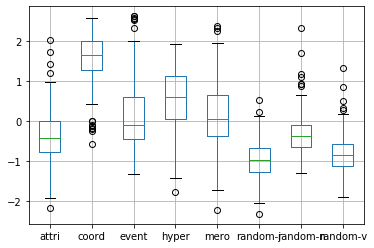

One-way ANOVA
F value: 319.02341440116817
P value: 1.2793165269500408e-297 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord  -0.0896 0.001 -0.0896 -0.0896   True
   attri    event   0.2886 0.001  0.2886  0.2886   True
   attri    hyper   0.9616 0.001  0.9616  0.9616   True
   attri     mero   0.0061 0.001  0.0061  0.0061   True
   attri random-j   0.9895 0.001  0.9895  0.9895   True
   attri random-n   1.0401 0.001  1.0401  1.0401   True
   attri random-v   3.1574 0.001  3.1574  3.1574   True
   coord    event   0.3781 0.001  0.3781  0.3781   True
   coord    hyper   1.0512 0.001  1.0512  1.0512   True
   coord     mero   0.0957 0.001  0.0957  0.0957   True
   coord random-j   1.0791 0.001  1.0791  1.0791   True
   coord random-n   1.1297 0.001  1.1297  1.1297   True
   coord random-v    3.247 0.001   3.247   3.247   True
   event    hyper   0.6731 

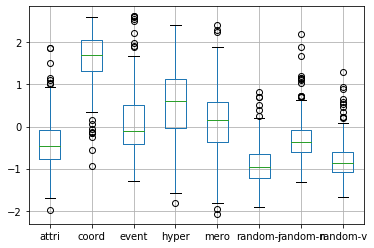

One-way ANOVA
F value: 311.49022277276697
P value: 7.851569033638251e-293 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.1039 0.001  0.1039  0.1039   True
   attri    event   0.2666 0.001  0.2666  0.2666   True
   attri    hyper   0.1687 0.001  0.1687  0.1687   True
   attri     mero   0.2383 0.001  0.2383  0.2383   True
   attri random-j   1.2477 0.001  1.2477  1.2477   True
   attri random-n   1.6384 0.001  1.6384  1.6384   True
   attri random-v   3.0326 0.001  3.0326  3.0326   True
   coord    event   0.1627 0.001  0.1627  0.1627   True
   coord    hyper   0.0648 0.001  0.0648  0.0648   True
   coord     mero   0.1344 0.001  0.1344  0.1344   True
   coord random-j   1.1438 0.001  1.1438  1.1438   True
   coord random-n   1.5344 0.001  1.5344  1.5344   True
   coord random-v   2.9287 0.001  2.9287  2.9287   True
   event    hyper  -0.0979 0

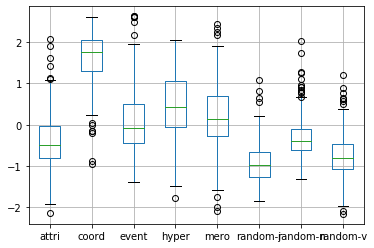

One-way ANOVA
F value: 297.73973872844397
P value: 6.441694847569653e-284 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   -0.148 0.001  -0.148  -0.148   True
   attri    event   0.1791 0.001  0.1791  0.1791   True
   attri    hyper  -0.0204 0.001 -0.0204 -0.0204   True
   attri     mero   0.6633 0.001  0.6633  0.6633   True
   attri random-j   0.0997 0.001  0.0997  0.0997   True
   attri random-n    0.896 0.001   0.896   0.896   True
   attri random-v   3.0853 0.001  3.0853  3.0853   True
   coord    event    0.327 0.001   0.327   0.327   True
   coord    hyper   0.1276 0.001  0.1276  0.1276   True
   coord     mero   0.8113 0.001  0.8113  0.8113   True
   coord random-j   0.2477 0.001  0.2477  0.2477   True
   coord random-n    1.044 0.001   1.044   1.044   True
   coord random-v   3.2333 0.001  3.2333  3.2333   True
   event    hyper  -0.1994 0

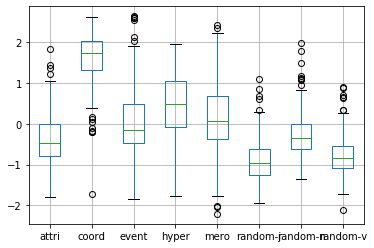

One-way ANOVA
F value: 289.9286802449066
P value: 9.479359671204382e-279 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.1421 0.001  0.1421  0.1421   True
   attri    event   0.6824 0.001  0.6824  0.6824   True
   attri    hyper  -0.1964 0.001 -0.1964 -0.1964   True
   attri     mero  -0.2898 0.001 -0.2898 -0.2898   True
   attri random-j   0.8693 0.001  0.8693  0.8693   True
   attri random-n  -0.0087 0.001 -0.0087 -0.0087   True
   attri random-v   2.9674 0.001  2.9674  2.9674   True
   coord    event   0.5403 0.001  0.5403  0.5403   True
   coord    hyper  -0.3385 0.001 -0.3385 -0.3385   True
   coord     mero  -0.4319 0.001 -0.4319 -0.4319   True
   coord random-j   0.7272 0.001  0.7272  0.7272   True
   coord random-n  -0.1508 0.001 -0.1508 -0.1508   True
   coord random-v   2.8253 0.001  2.8253  2.8253   True
   event    hyper  -0.8788 0.

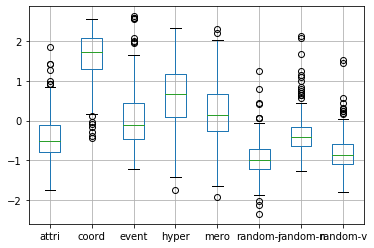

One-way ANOVA
F value: 342.5402853173315
P value: 3.73498171668e-312 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord  -0.2512 0.001 -0.2512 -0.2512   True
   attri    event  -0.1577 0.001 -0.1577 -0.1577   True
   attri    hyper    0.172 0.001   0.172   0.172   True
   attri     mero   0.4681 0.001  0.4681  0.4681   True
   attri random-j  -0.3699 0.001 -0.3699 -0.3699   True
   attri random-n   0.4477 0.001  0.4477  0.4477   True
   attri random-v   2.9404 0.001  2.9404  2.9404   True
   coord    event   0.0934 0.001  0.0934  0.0934   True
   coord    hyper   0.4232 0.001  0.4232  0.4232   True
   coord     mero   0.7193 0.001  0.7193  0.7193   True
   coord random-j  -0.1188 0.001 -0.1188 -0.1188   True
   coord random-n   0.6989 0.001  0.6989  0.6989   True
   coord random-v   3.1915 0.001  3.1915  3.1915   True
   event    hyper   0.3298 0.001 

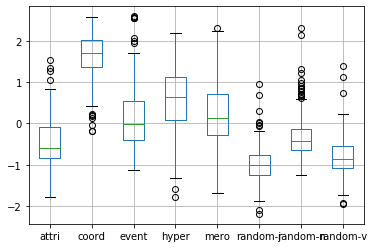

One-way ANOVA
F value: 374.18724461821114
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord  -0.1729 0.001 -0.1729 -0.1729   True
   attri    event   0.1923 0.001  0.1923  0.1923   True
   attri    hyper   0.6786 0.001  0.6786  0.6786   True
   attri     mero  -0.3111 0.001 -0.3111 -0.3111   True
   attri random-j   0.5252 0.001  0.5252  0.5252   True
   attri random-n   0.2228 0.001  0.2228  0.2228   True
   attri random-v   3.0375 0.001  3.0375  3.0375   True
   coord    event   0.3651 0.001  0.3651  0.3651   True
   coord    hyper   0.8515 0.001  0.8515  0.8515   True
   coord     mero  -0.1382 0.001 -0.1382 -0.1382   True
   coord random-j   0.6981 0.001  0.6981  0.6981   True
   coord random-n   0.3957 0.001  0.3957  0.3957   True
   coord random-v   3.2104 0.001  3.2104  3.2104   True
   event    hyper   0.4863 0.001  0.4863  0.486

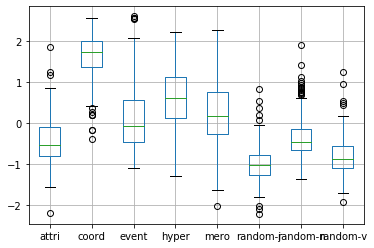

One-way ANOVA
F value: 375.14605127183233
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.3056 0.001  0.3056  0.3056   True
   attri    event  -0.1454 0.001 -0.1454 -0.1454   True
   attri    hyper   0.3223 0.001  0.3223  0.3223   True
   attri     mero   1.2478 0.001  1.2478  1.2478   True
   attri random-j   0.7919 0.001  0.7919  0.7919   True
   attri random-n   1.2911 0.001  1.2911  1.2911   True
   attri random-v   3.1651 0.001  3.1651  3.1651   True
   coord    event  -0.4509 0.001 -0.4509 -0.4509   True
   coord    hyper   0.0168 0.001  0.0168  0.0168   True
   coord     mero   0.9422 0.001  0.9422  0.9422   True
   coord random-j   0.4864 0.001  0.4864  0.4864   True
   coord random-n   0.9856 0.001  0.9856  0.9856   True
   coord random-v   2.8595 0.001  2.8595  2.8595   True
   event    hyper   0.4677 0.001  0.4677  0.467

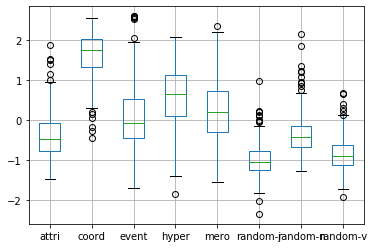

One-way ANOVA
F value: 373.9291944957866
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.5646 0.001  0.5646  0.5646   True
   attri    event   0.1924 0.001  0.1924  0.1924   True
   attri    hyper    0.142 0.001   0.142   0.142   True
   attri     mero   1.1691 0.001  1.1691  1.1691   True
   attri random-j   0.8773 0.001  0.8773  0.8773   True
   attri random-n   0.5635 0.001  0.5635  0.5635   True
   attri random-v   3.3153 0.001  3.3153  3.3153   True
   coord    event  -0.3722 0.001 -0.3722 -0.3722   True
   coord    hyper  -0.4226 0.001 -0.4226 -0.4226   True
   coord     mero   0.6045 0.001  0.6045  0.6045   True
   coord random-j   0.3126 0.001  0.3126  0.3126   True
   coord random-n  -0.0011 0.001 -0.0011 -0.0011   True
   coord random-v   2.7507 0.001  2.7507  2.7507   True
   event    hyper  -0.0504 0.001 -0.0504 -0.0504

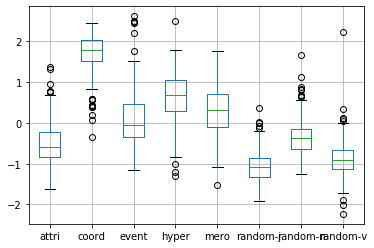

One-way ANOVA
F value: 581.4662090380384
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord  -0.1368 0.001 -0.1368 -0.1368   True
   attri    event   0.4968 0.001  0.4968  0.4968   True
   attri    hyper   1.2449 0.001  1.2449  1.2449   True
   attri     mero   0.9633 0.001  0.9633  0.9633   True
   attri random-j   1.5538 0.001  1.5538  1.5538   True
   attri random-n   0.6689 0.001  0.6689  0.6689   True
   attri random-v   3.2309 0.001  3.2309  3.2309   True
   coord    event   0.6336 0.001  0.6336  0.6336   True
   coord    hyper   1.3817 0.001  1.3817  1.3817   True
   coord     mero   1.1001 0.001  1.1001  1.1001   True
   coord random-j   1.6907 0.001  1.6907  1.6907   True
   coord random-n   0.8058 0.001  0.8058  0.8058   True
   coord random-v   3.3677 0.001  3.3677  3.3677   True
   event    hyper   0.7481 0.001  0.7481  0.7481

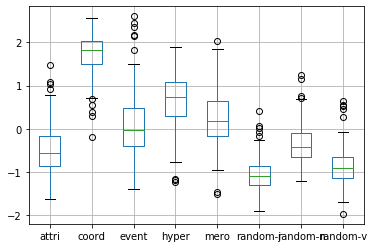

One-way ANOVA
F value: 595.76362450686
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord  -0.6834 0.001 -0.6834 -0.6834   True
   attri    event  -0.6009 0.001 -0.6009 -0.6009   True
   attri    hyper   0.6216 0.001  0.6216  0.6216   True
   attri     mero  -0.3673 0.001 -0.3673 -0.3673   True
   attri random-j  -0.3553 0.001 -0.3553 -0.3553   True
   attri random-n   0.9565 0.001  0.9565  0.9565   True
   attri random-v   2.4766 0.001  2.4766  2.4766   True
   coord    event   0.0825 0.001  0.0825  0.0825   True
   coord    hyper    1.305 0.001   1.305   1.305   True
   coord     mero   0.3161 0.001  0.3161  0.3161   True
   coord random-j    0.328 0.001   0.328   0.328   True
   coord random-n   1.6399 0.001  1.6399  1.6399   True
   coord random-v     3.16 0.001    3.16    3.16   True
   event    hyper   1.2225 0.001  1.2225  1.2225  

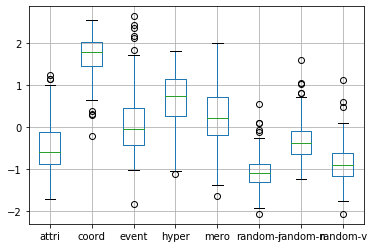

One-way ANOVA
F value: 557.7725913924132
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.1273 0.001  0.1273  0.1273   True
   attri    event   0.5414 0.001  0.5414  0.5414   True
   attri    hyper   1.4028 0.001  1.4028  1.4028   True
   attri     mero   0.7034 0.001  0.7034  0.7034   True
   attri random-j   0.5454 0.001  0.5454  0.5454   True
   attri random-n   1.5657 0.001  1.5657  1.5657   True
   attri random-v   3.2924 0.001  3.2924  3.2924   True
   coord    event   0.4141 0.001  0.4141  0.4141   True
   coord    hyper   1.2755 0.001  1.2755  1.2755   True
   coord     mero   0.5761 0.001  0.5761  0.5761   True
   coord random-j   0.4181 0.001  0.4181  0.4181   True
   coord random-n   1.4384 0.001  1.4384  1.4384   True
   coord random-v   3.1651 0.001  3.1651  3.1651   True
   event    hyper   0.8614 0.001  0.8614  0.8614

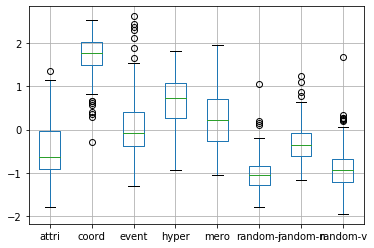

One-way ANOVA
F value: 551.441093100733
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.2204 0.001  0.2204  0.2204   True
   attri    event   0.6402 0.001  0.6402  0.6402   True
   attri    hyper   0.7245 0.001  0.7245  0.7245   True
   attri     mero   1.3891 0.001  1.3891  1.3891   True
   attri random-j   0.5698 0.001  0.5698  0.5698   True
   attri random-n   1.5947 0.001  1.5947  1.5947   True
   attri random-v   3.3509 0.001  3.3509  3.3509   True
   coord    event   0.4197 0.001  0.4197  0.4197   True
   coord    hyper   0.5041 0.001  0.5041  0.5041   True
   coord     mero   1.1686 0.001  1.1686  1.1686   True
   coord random-j   0.3493 0.001  0.3493  0.3493   True
   coord random-n   1.3743 0.001  1.3743  1.3743   True
   coord random-v   3.1305 0.001  3.1305  3.1305   True
   event    hyper   0.0843 0.001  0.0843  0.0843 

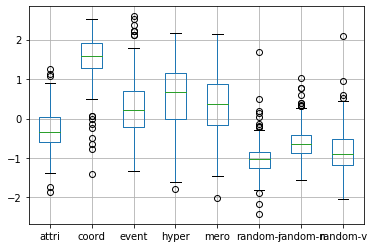

One-way ANOVA
F value: 373.30178910153353
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.4124 0.001  0.4124  0.4124   True
   attri    event   0.6692 0.001  0.6692  0.6692   True
   attri    hyper   1.0427 0.001  1.0427  1.0427   True
   attri     mero   0.9356 0.001  0.9356  0.9356   True
   attri random-j   2.1114 0.001  2.1114  2.1114   True
   attri random-n   2.1204 0.001  2.1204  2.1204   True
   attri random-v    3.196 0.001   3.196   3.196   True
   coord    event   0.2568 0.001  0.2568  0.2568   True
   coord    hyper   0.6303 0.001  0.6303  0.6303   True
   coord     mero   0.5233 0.001  0.5233  0.5233   True
   coord random-j    1.699 0.001   1.699   1.699   True
   coord random-n    1.708 0.001   1.708   1.708   True
   coord random-v   2.7837 0.001  2.7837  2.7837   True
   event    hyper   0.3735 0.001  0.3735  0.373

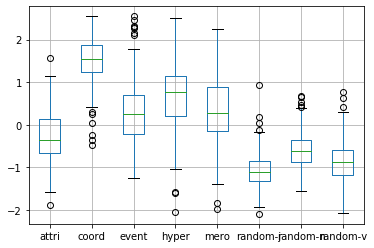

One-way ANOVA
F value: 422.6094092794259
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.1997 0.001  0.1997  0.1997   True
   attri    event   0.8161 0.001  0.8161  0.8161   True
   attri    hyper   0.0109 0.001  0.0109  0.0109   True
   attri     mero   2.0854 0.001  2.0854  2.0854   True
   attri random-j   1.6756 0.001  1.6756  1.6756   True
   attri random-n   0.8723 0.001  0.8723  0.8723   True
   attri random-v   2.9341 0.001  2.9341  2.9341   True
   coord    event   0.6165 0.001  0.6165  0.6165   True
   coord    hyper  -0.1888 0.001 -0.1888 -0.1888   True
   coord     mero   1.8857 0.001  1.8857  1.8857   True
   coord random-j   1.4759 0.001  1.4759  1.4759   True
   coord random-n   0.6727 0.001  0.6727  0.6727   True
   coord random-v   2.7344 0.001  2.7344  2.7344   True
   event    hyper  -0.8053 0.001 -0.8053 -0.8053

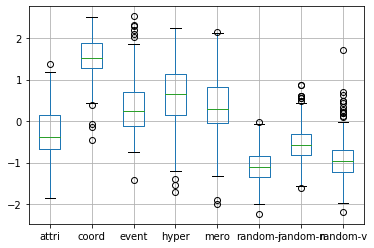

One-way ANOVA
F value: 432.48440007304504
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
   attri    coord   0.4063 0.001  0.4063  0.4063   True
   attri    event   2.1165 0.001  2.1165  2.1165   True
   attri    hyper   0.4523 0.001  0.4523  0.4523   True
   attri     mero  -0.1869 0.001 -0.1869 -0.1869   True
   attri random-j   0.7803 0.001  0.7803  0.7803   True
   attri random-n   1.1221 0.001  1.1221  1.1221   True
   attri random-v   2.9103 0.001  2.9103  2.9103   True
   coord    event   1.7101 0.001  1.7101  1.7101   True
   coord    hyper   0.0459 0.001  0.0459  0.0459   True
   coord     mero  -0.5932 0.001 -0.5932 -0.5932   True
   coord random-j    0.374 0.001   0.374   0.374   True
   coord random-n   0.7158 0.001  0.7158  0.7158   True
   coord random-v   2.5039 0.001  2.5039  2.5039   True
   event    hyper  -1.6642 0.001 -1.6642 -1.664

KeyboardInterrupt: 

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import zscore

import collections

from scipy.spatial.distance import cosine

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


results_file = './data/bnc_cluster_analysis_BLESS_similarity_results.csv'
fieldnames = ['layer', 'k_clusters', 'tukey_HSD']
with open(results_file, mode='w') as disk:
    writer = csv.DictWriter(disk, delimiter='\t', fieldnames=fieldnames)

    for layer_number in layers:
        for k in cluster_sizes:

            data = bless

            bless_similarities = {}
            for row in data:
                concept = row['word1']
                relatum = row['word2']
                relation = row['relation']

                # get centroid data for these words at this layer and this k size
                pairwise_centroids = {}
                for word in [concept, relatum]:
                    cluster_filename = "layer_" + str(layer_number) + "_clusters_k_equals_" + str(k) + ".csv"
                    cluster_path = os.path.join('./data/word_data/', word, 'analysis_results', cluster_filename)
                    
                    try:
                        with open(cluster_path, mode='r') as csv_file:
                            fieldnames = ['word', 'clusternumber', 'centroid', 'sentence_uids']
                            reader = csv.DictReader(csv_file, delimiter='\t', fieldnames=fieldnames)

                            word_centroids = []
                            for line in reader:
                                centroid = np.fromstring(line['centroid'][2:-2], dtype=np.float, sep=' ')
                                word_centroids.append(centroid)
                            pairwise_centroids[word] = word_centroids
                    except:
                        None
                        #print("can't calculate predicted similarity for pair %s, %s" %(concept, relatum))
                        #print("   no tokens collected for %s" % word)

                predicted_similarities = []
                if (concept in pairwise_centroids) and (relatum in pairwise_centroids):

                    for centroid1 in pairwise_centroids[concept]:
                        for centroid2 in pairwise_centroids[relatum]:
                            predicted_similarity = 1 - cosine(centroid1, centroid2)
                            predicted_similarities.append(predicted_similarity)

                    # find the max of the pairwise similarities
                    max_sim = max(predicted_similarities)
                    row[max_sim] = max_sim
                    
                    # find the avg of the pairwise similarities
                    avg_sim = np.sum(predicted_similarities) / k*k
                    row['avg_sim'] = avg_sim
                else:
                    row['max_sim'] = None
                    row['avg_sim'] = None

 
                if concept not in bless_similarities:
                    bless_similarities[concept] = {}
                
                # keep the relatum similarity that is the best for that relation
                if relation in bless_similarities[concept]:
                    bless_similarities[concept][relation] = max(max_sim, bless_similarities[concept][relation])
                else:
                    bless_similarities[concept][relation] = max_sim

            result = []
            for word in bless_similarities.values():
                # do zscore normalization
                #sims = [x for x in word.values()]
                vals = [x for x in word.values()]
                normalized_sims = zscore(vals)
                result.append(dict(zip(word.keys(), normalized_sims)))

            #result2 = collections.defaultdict(list)
            result2 = {'attri': [],
                       'coord': [],
                       'event': [],
                       'hyper': [],
                       'mero': [],
                       'random-j': [],
                       'random-n': [],
                       'random-v': []
                      }
            
            for row in result:
                for key, val in row.items():
                    result2[key].append(val)
            
            
            # Chart boxplots for this layer
            print("boxplot for layer %s with num clusters %s" % (layer_number,k))
            
            df = pd.DataFrame(result2)
            boxplot = df.boxplot()
            plt.show()

            # do anova for this layer
            f, p = f_oneway(df['attri'],
                      df['coord'],
                       df['event'],
                       df['hyper'],
                       df['mero'],
                       df['random-j'],
                       df['random-n'],
                       df['random-v'])

            print ('One-way ANOVA')
            print ('=============')

            print ('F value:', f)
            print ('P value:', p, '\n')

            normalized_attrs = []
            normalized_vals = []
            for attr, vals in result2.items():
                for val in vals:
                    normalized_attrs.append(attr)
                    normalized_vals.append(vals)


            # do Tukey HSD test for this layeer
            mc = MultiComparison(normalized_vals, normalized_attrs)
            result = mc.tukeyhsd()
            
            print(result)
            output = {'layer': layer_number,
                      'k_clusters': k,
                      'tukey_HSD': result
                     }
            writer.writerow(output)


### Analysis of how BERT changes throughout the layers with respect to the similarity between words with particular relations. 

You still want to normalize. 
Do you still want to normalize? I'm not sure

For each layer
    For each number of clusters
        for each target word:
            for each relation:
                 for each relatum in relation:
                        sim = MaxSim(target_word, relatum)
            average = what is the average similarity between the word and each relatum bearing this relation?
            write row = store this average (layer, k, target, relation)
     

    


In [96]:
results_file = './data/BLESS_average_similarity_to_target_by_relation.csv'
fieldnames = ['layer', 'k_clusters', 'relation', 'average_max_sim_to_target']

with open(results_file, mode='w') as disk:
    writer = csv.DictWriter(disk, delimiter='\t', fieldnames=fieldnames)
    
    for layer_number in layers:
        for k in cluster_sizes:
            
            averages = {}
            """
            will eventuallly look like
                        {
                   'attri': [],
                   'coord': [],
                   'event': [],
                   'hyper': [],
                   'mero': [],
                   'random-j': [],
                   'random-n': [],
                   'random-v': []
                  }   

            """

            
            bless_similarities = get_bless_similarities_for_layer_and_cluster(layer_number, k)
            
            print(len(bless_similarities))
            for row in bless_similarities:
                this_sim = row['max_sim']
                if this_sim != None:
                    relation = row['relation']
                    if relation in averages:
                        averages[relation] = (averages[relation] + this_sim ) / 2
                    else:
                        averages[relation] = this_sim
            
            print(averages)
            for relation,average in averages.items():
                output = {'layer': layer_number,
                          'k_clusters': k,
                          'relation': relation,
                          'average_max_sim_to_target': average,
                         }
                writer.writerow(output)
         

processed 26554 word pairs from BLESS dataset
26554
{'attri': 0.11139473375316827, 'coord': 0.39612119386024314, 'event': 0.1550390323813774, 'hyper': 0.338570472949785, 'mero': 0.21524805078768322, 'random-j': 0.03087807239089417, 'random-n': 0.11807088534868079, 'random-v': 0.019397966089044184}
processed 26554 word pairs from BLESS dataset
26554
{'attri': 0.1439982733964899, 'coord': 0.40966669156007646, 'event': 0.182055399881885, 'hyper': 0.35420861228585776, 'mero': 0.25204784417901693, 'random-j': 0.13290795744984116, 'random-n': 0.19104597426632727, 'random-v': 0.13247250910427238}
processed 26554 word pairs from BLESS dataset
26554
{'attri': 0.1418097373132641, 'coord': 0.42496792848581744, 'event': 0.19317577455582555, 'hyper': 0.36423310867821934, 'mero': 0.259394297872425, 'random-j': 0.1420283964215488, 'random-n': 0.21030304921123488, 'random-v': 0.11519702634025383}
processed 26554 word pairs from BLESS dataset
26554
{'attri': 0.16046459895523257, 'coord': 0.433786079708

now, for each relation (of 8)
    what is that average similarity over the layers? (for clusters = 0)
    what is the average similarity over the layers (for clusters = 5)

relation     attri     coord     event     hyper      mero  random-j  \
layer                                                                  
0         0.111395  0.396121  0.155039  0.338570  0.215248  0.030878   
1         0.160592  0.426698  0.194394  0.365021  0.210680  0.081740   
5         0.315774  0.704190  0.387103  0.530360  0.484175  0.258453   
11        0.417997  0.732463  0.491535  0.563266  0.597641  0.433552   

relation  random-n  random-v  
layer                         
0         0.118071  0.019398  
1         0.161529  0.001018  
5         0.424547  0.238971  
11        0.348661  0.469292  


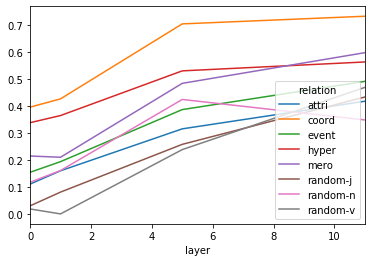

In [147]:
import matplotlib.pyplot as plt


results_file = './data/BLESS_average_similarity_to_target_by_relation.csv'
fieldnames = ['layer', 'k_clusters', 'relation', 'average_max_sim_to_target']


with open(results_file, mode='r') as disk:
    reader = csv.DictReader(disk, delimiter='\t', fieldnames=fieldnames)
    
    data = [row for row in reader]
    for row in data:
        row['layer'] = int(row['layer'])
        row['k_clusters'] = int(row['k_clusters'])
        row['average_max_sim_to_target'] = float(row['average_max_sim_to_target'])
    
    relations =  {
                   'attri': [],
                   'coord': [],
                   'event': [],
                   'hyper': [],
                   'mero': [],
                   'random-j': [],
                   'random-n': [],
                   'random-v': []
                  } 

    df = pd.DataFrame.from_records(data, columns=fieldnames, coerce_float=True)
    
    df1 = df[df['k_clusters'] == 1]

    df2 = df1.pivot(index='layer', columns='relation', values='average_max_sim_to_target')
    print(df2)

#     plt.plot(df2,)
#     plt.legend()
#     plt.tight_layout()

#     plt.show()
    df2.plot()

Now do you want to look, for a single layer, how does clustering affect the relations...yea?


So. start with your dataframe
    for each layer
        make a new dataframe with just that layer. 




Layer 0
relation       attri     coord     event     hyper      mero  random-j  \
k_clusters                                                               
1           0.111395  0.396121  0.155039  0.338570  0.215248  0.030878   
3           0.143998  0.409667  0.182055  0.354209  0.252048  0.132908   
5           0.141810  0.424968  0.193176  0.364233  0.259394  0.142028   
7           0.160465  0.433786  0.210645  0.370091  0.275332  0.147564   

relation    random-n  random-v  
k_clusters                      
1           0.118071  0.019398  
3           0.191046  0.132473  
5           0.210303  0.115197  
7           0.203407  0.087562  


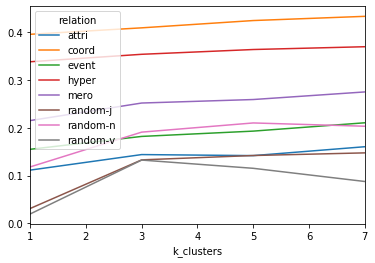

Layer 1
relation       attri     coord     event     hyper      mero  random-j  \
k_clusters                                                               
1           0.160592  0.426698  0.194394  0.365021  0.210680  0.081740   
3           0.176134  0.475458  0.223485  0.400773  0.233472  0.133927   
5           0.193856  0.493458  0.284589  0.411550  0.286340  0.146223   
7           0.200489  0.499893  0.292952  0.419405  0.306019  0.156854   

relation    random-n  random-v  
k_clusters                      
1           0.161529  0.001018  
3           0.249762  0.139332  
5           0.260427  0.137075  
7           0.265652  0.162612  


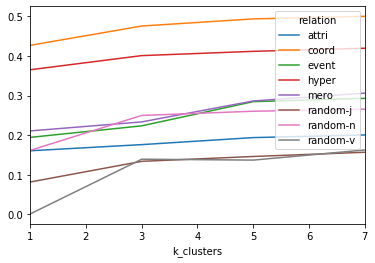

Layer 5
relation       attri     coord     event     hyper      mero  random-j  \
k_clusters                                                               
1           0.315774  0.704190  0.387103  0.530360  0.484175  0.258453   
3           0.364074  0.722819  0.421980  0.544470  0.506713  0.355101   
5           0.393265  0.725582  0.466343  0.548840  0.506616  0.357591   
7           0.407874  0.723835  0.478645  0.560356  0.520641  0.365852   

relation    random-n  random-v  
k_clusters                      
1           0.424547  0.238971  
3           0.399597  0.270925  
5           0.415033  0.303129  
7           0.440362  0.350722  


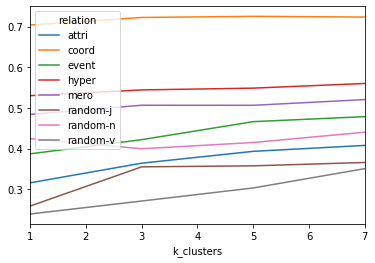

Layer 11
relation       attri     coord     event     hyper      mero  random-j  \
k_clusters                                                               
1           0.417997  0.732463  0.491535  0.563266  0.597641  0.433552   
3           0.529433  0.734053  0.565327  0.642885  0.634398  0.481135   
5           0.526597  0.740076  0.553227  0.630774  0.621940  0.461162   
7           0.552182  0.741505  0.565466  0.672396  0.623354  0.481510   

relation    random-n  random-v  
k_clusters                      
1           0.348661  0.469292  
3           0.514650  0.505398  
5           0.499232  0.500083  
7           0.499496  0.513040  


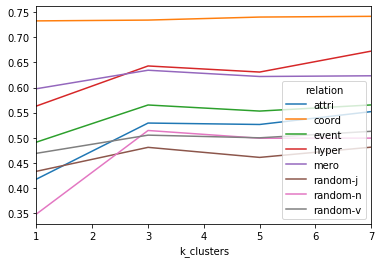

In [152]:
for layer in layers:
    sub_df = df[df['layer'] == layer]

    sub_sub_df = sub_df.pivot(index='k_clusters', columns='relation', values='average_max_sim_to_target')
    print("Layer %s" % layer)
    print(sub_sub_df)
    sub_sub_df.plot()
    plt.show()

In [ ]:
DO you also want to look at the same thing as above, but with normalization?
So you can remove the effect of the cone of similarity shrinking through the layers,
and just see the differences. Would this allow you to see the differences?
